# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need? in thin the
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

### Download missing libraries
Comment in the following two lines in case some of the libraries cannot be imported. Please restart the kernel after download+upgrade has successfully finished

In [101]:
### Download libraries
#%pip install uproot 
#%pip install awkward 
#%pip install mplhep 
#%pip install numpy 
#%pip install matplotlib 
#%pip install scipy

### Upgrade libraries to latest version
#%pip install uproot awkward mplhep numpy matplotlib scipy --upgrade

### Import libraries

In [102]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

## *Example*: Reading a ROOT.TTree and plotting a variable with a cut

We will open data and Monte Carlo samples using **uproot**. Uproot is a reader and a writer of the ROOT file format using only Python and Numpy. Unlike PyROOT and root_numpy, uproot does not depend on C++ ROOT so that no local compilation of the ROOT libraries is needed to access the data.

You can find more info on uproot following the references:
* Github repo: https://github.com/scikit-hep/uproot4
* Tutorial: https://masonproffitt.github.io/uproot-tutorial/
* Video tutorial on uproot and awkward arrays:  https://www.youtube.com/embed/ea-zYLQBS4U 

First, let's specify the folder path for both data and Monte Carlo (MC) samples

In [103]:
## Take folder with samples from Google Drive
#%pip install google-colab
#from google.colab import drive
#import os
#samplefolder = drive.mount('samples')
#path_data = 'opal_data/mc/'
path_mc = 'opal_data/mc/'


### Open the file introducing file path
#file = uproot.open(path_data+'daten.root')
fileee = uproot.open(path_mc+'ee.root')
filemm = uproot.open(path_mc+'mm.root')
filett = uproot.open(path_mc+'tt.root')
fileqq = uproot.open(path_mc+'qq.root')

files = [fileee, filemm, filett, fileqq]

ttree_name = 'myTTree'

### Print list of 'branches' of the TTree (i.e. list of variable names)
#print(file[ttree_name].keys())

## Load branches
branchesee = files[0][ttree_name].arrays() #Electronic brances of the MC data
branchesmm = files[1][ttree_name].arrays() #Muonic brances ''
branchestt = files[2][ttree_name].arrays() #Tauon branches ''
branchesqq = files[3][ttree_name].arrays() #Quarks ''


branchessum = 0
branchesREAL = 0



brancheses = [branchesee, branchesmm, branchestt, branchesqq, branchessum, branchesREAL] #List of all Branches

## Define an numpy array for 'Pcharged'
var = 'Pcharged'
var2 = 'E_lep'
#pcharee = ak.to_numpy(branchesee[var]) # See Docu (https://awkward-array.org/how-to-convert-numpy.html) for more conversions

var = ['Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'E_lep', 'cos_thru', 'cos_thet', 'run', 'event']

pchares = [0] * 6 # 4 Times the MC data, 1 time the sum of MC and 1 Time the measured data
nchares = [0] * 6
eecal = [0] * 6
ehcal = [0] * 6
elep = [0] * 6
costhru = [0] * 6
costhet = [0] * 6

run = [0] * 6
event = [0] * 6
i = 0
while i < 4:
    nchares[i] = ak.to_numpy(brancheses[i][var[0]]) #copy from strange array to nomal array.
    pchares[i] = ak.to_numpy(brancheses[i][var[1]])
    eecal[i] = ak.to_numpy(brancheses[i][var[2]])
    ehcal[i] = ak.to_numpy(brancheses[i][var[3]])
    elep[i] = ak.to_numpy(brancheses[i][var[4]])
    costhru[i] = ak.to_numpy(brancheses[i][var[5]])
    costhet[i] = ak.to_numpy(brancheses[i][var[6]])
    run[i] = ak.to_numpy(brancheses[i][var[7]])
    event[i] = ak.to_numpy(brancheses[i][var[8]])
    i += 1

nchares[4] = np.concatenate((nchares[:4]),axis=None) # Sum the MC data to a total array
pchares[4] = np.concatenate((pchares[:4]),axis=None)
eecal[4] = np.concatenate((eecal[:4]),axis=None)
ehcal[4] = np.concatenate((ehcal[:4]),axis=None)
elep[4] = np.concatenate((elep[:4]),axis=None)
costhru[4] = np.concatenate((costhru[:4]),axis=None)
costhet[4] = np.concatenate((costhet[:4]),axis=None)
run[4] = np.concatenate((run[:4]),axis=None)
event[4] = np.concatenate((event[:4]),axis=None)


brancheses[4] = ak.Array([
    {"run": run[4], "event": event[4], 'Ncharged' : nchares[4], 'Pcharged' : pchares[4], 'E_ecal' : eecal[4], 'E_hcal' : ehcal[4], 'E_lep' : elep[4], 'cos_thru' : costhru[4], 'cos_thet' : costhet[4]} # Re create a "high level array", for the MC cummulative data.
    ])


The last line shows all the variables available in the TTree to carry out the experiment. The meaning of these is described in the following table

| Variable name | Description |
| --- | --- | 
| <pre>run</pre> | Run number |
| <pre>event</pre> | Event number |
| <pre>Ncharged</pre> | Number of charged tracks |
| <pre>Pcharged</pre> | Total scalar sum of track momenta |
| <pre>E_ecal</pre> | Total energy measured in the electromagnetic calorimeter |
| <pre>E_hcal</pre> | Total energy measured in the hadronic calorimete |
| <pre>E_lep</pre> | LEP beam energy (=$\sqrt{s}/2$) |
| <pre>cos_thru</pre> | cosine of the polar angle between beam axis and thrust axis |
| <pre>cos_thet</pre> | cosine of the polar angle between incoming positron and outgoing positive particle |

We proceed to plot *PCharged* for illustration.

You can find all features provided by the function *matplotlib.pyplot.hist()* in the **matplotlib documentation**: https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.hist.html

### Apply a cut

Cuts are applied by *masking* the array. This can be done as follows:

### Some useful information about your selection

### Make a plot with a certain selection

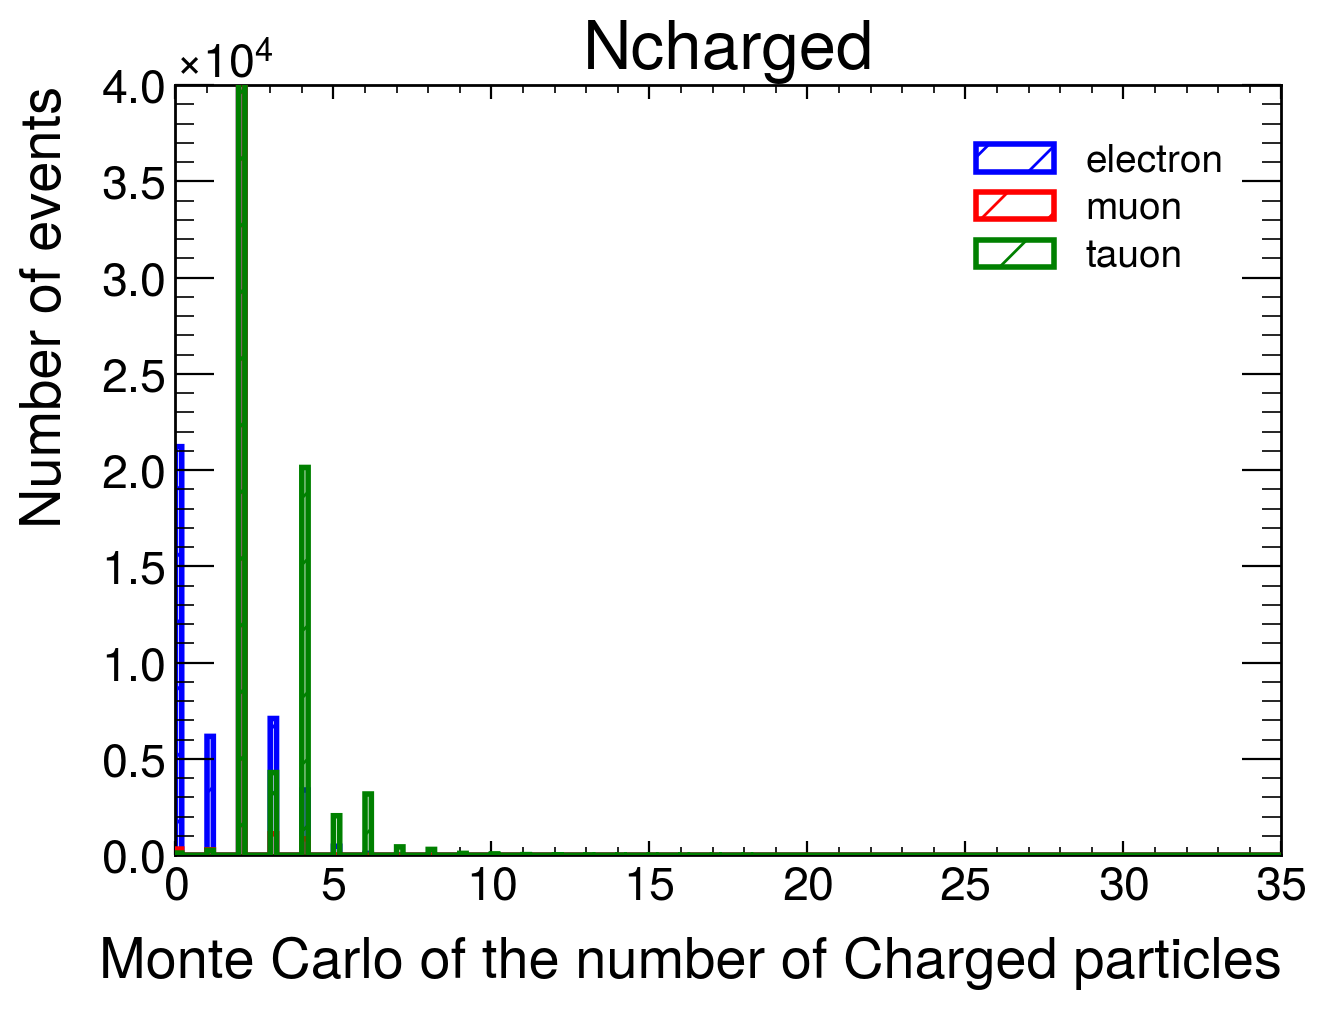

In [104]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(nchares[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='electron', zorder=2)
bin_content, bin_edges, _ = plt.hist(nchares[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='muon', zorder=3)
bin_content, bin_edges, _ = plt.hist(nchares[2], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='tauon', zorder=5)
#bin_content, bin_edges, _ = plt.hist(nchares[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='hadronic', zorder=4)
#bin_content, bin_edges, _ = plt.hist(nchares[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[0])
plt.xlim(0.,35)
plt.ylim(0,40e3)
plt.xlabel('Monte Carlo of the number of Charged particles')
plt.ylabel('Number of events')
plt.show()

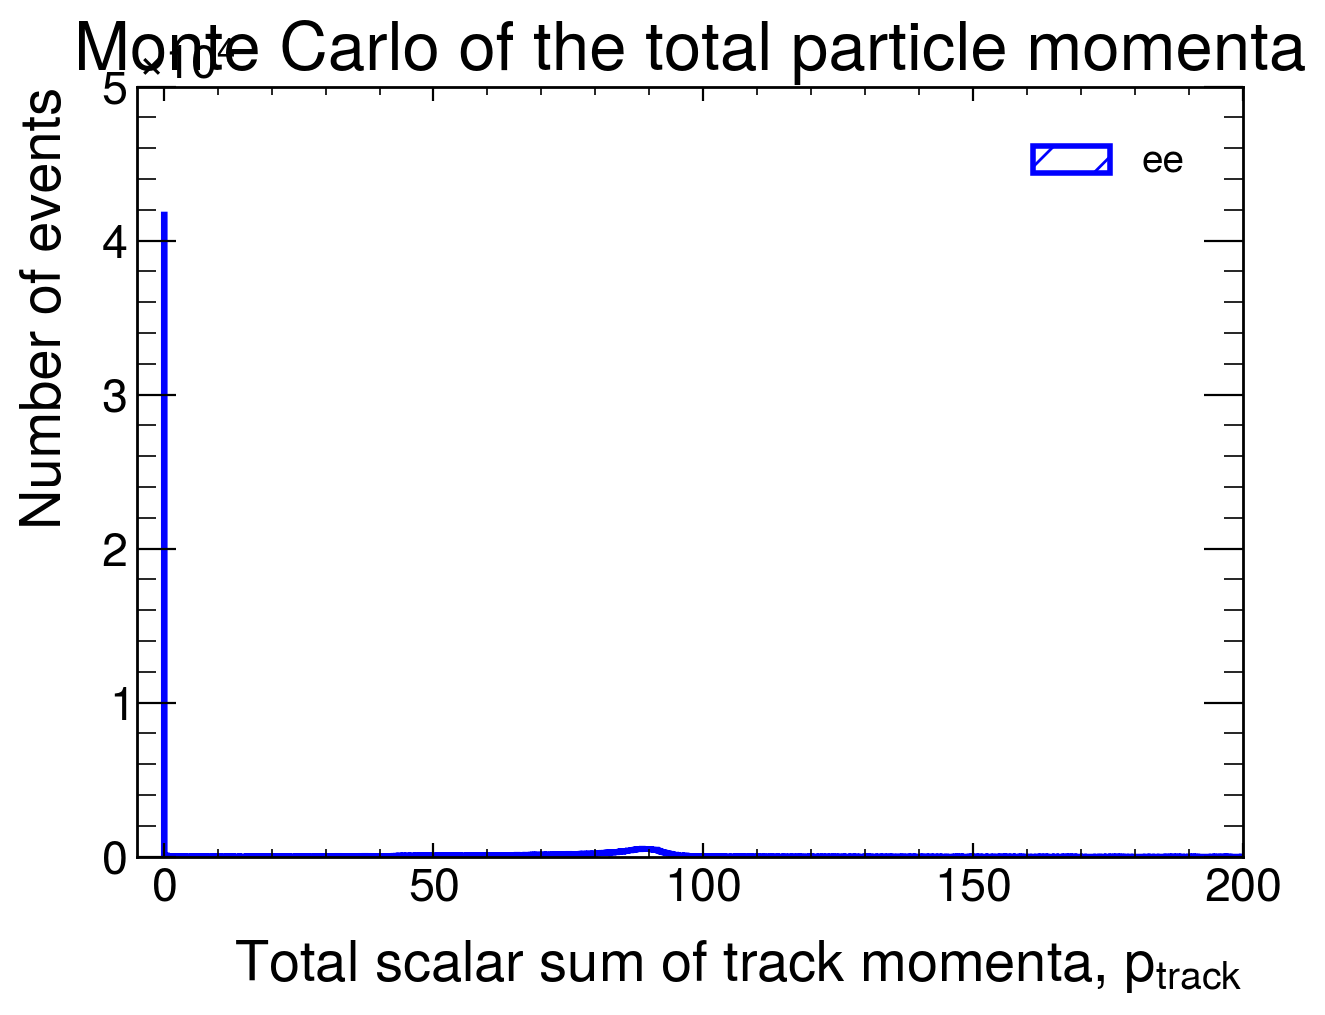

In [105]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(pchares[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='ee')
#bin_content, bin_edges, _ = plt.hist(pchares[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='mm')
#bin_content, bin_edges, _ = plt.hist(pchares[2], bins=1000, range=(0.,200), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='tt')
#bin_content, bin_edges, _ = plt.hist(pchares[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='qq')
#bin_content, bin_edges, _ = plt.hist(pchares[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title('Monte Carlo of the total particle momenta')
#plt.xlim(-5,130.)
plt.xlim(-5,200)
plt.ylim(0,0.5e5)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

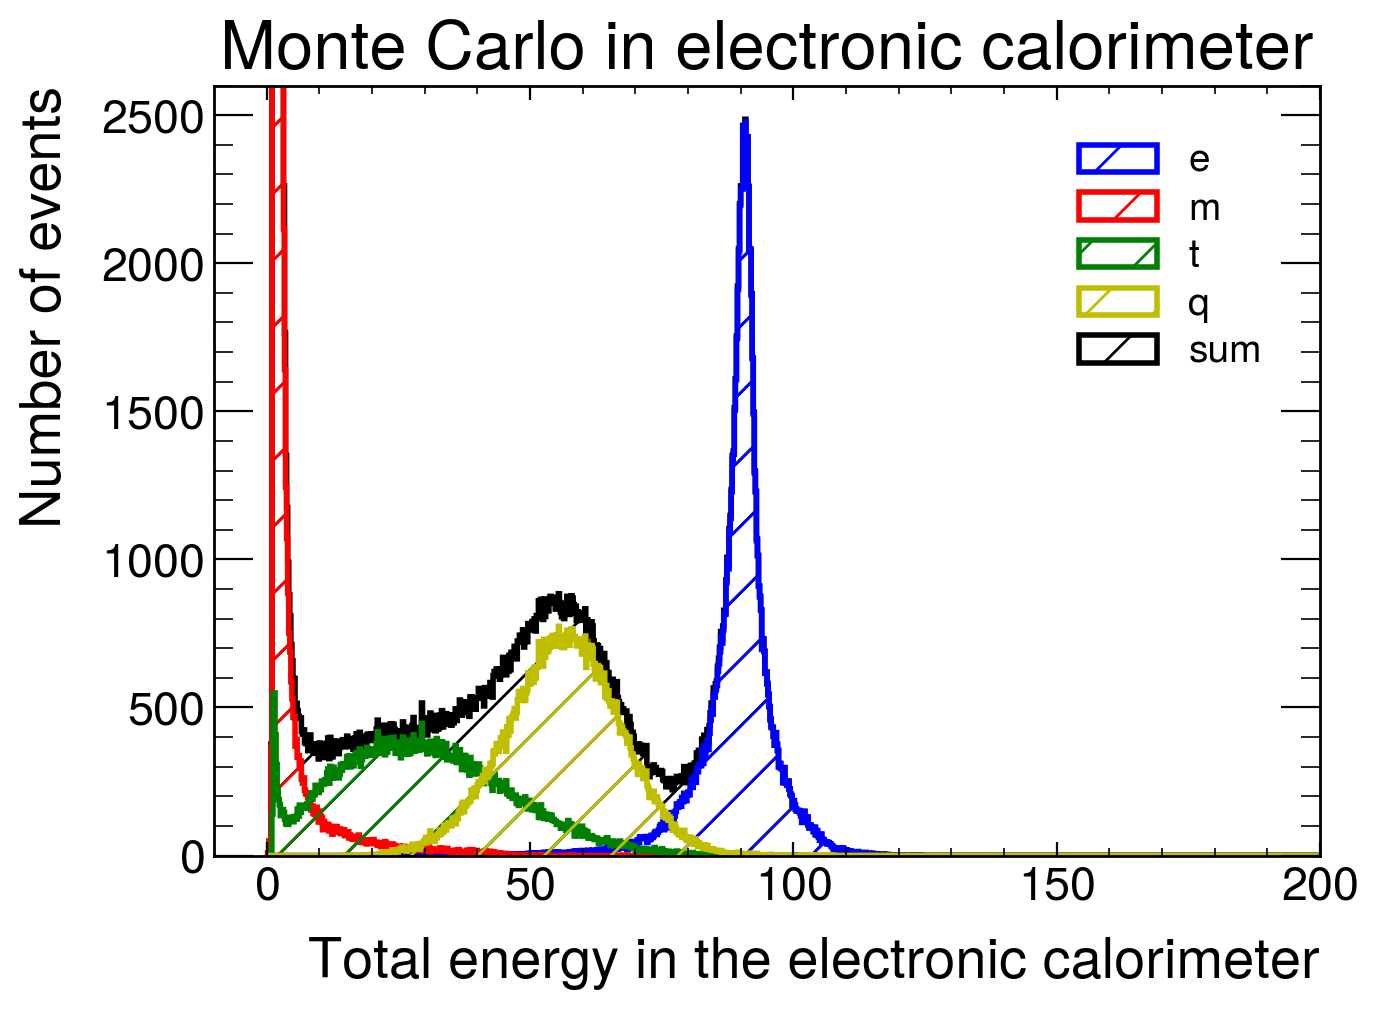

In [106]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(eecal[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(eecal[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(eecal[2], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(eecal[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')
bin_content, bin_edges, _ = plt.hist(eecal[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title('Monte Carlo in electronic calorimeter')
plt.xlim(-10.,200.)
plt.ylim(0,2.6e3)
plt.xlabel('Total energy in the electronic calorimeter')
plt.ylabel('Number of events')
plt.show()

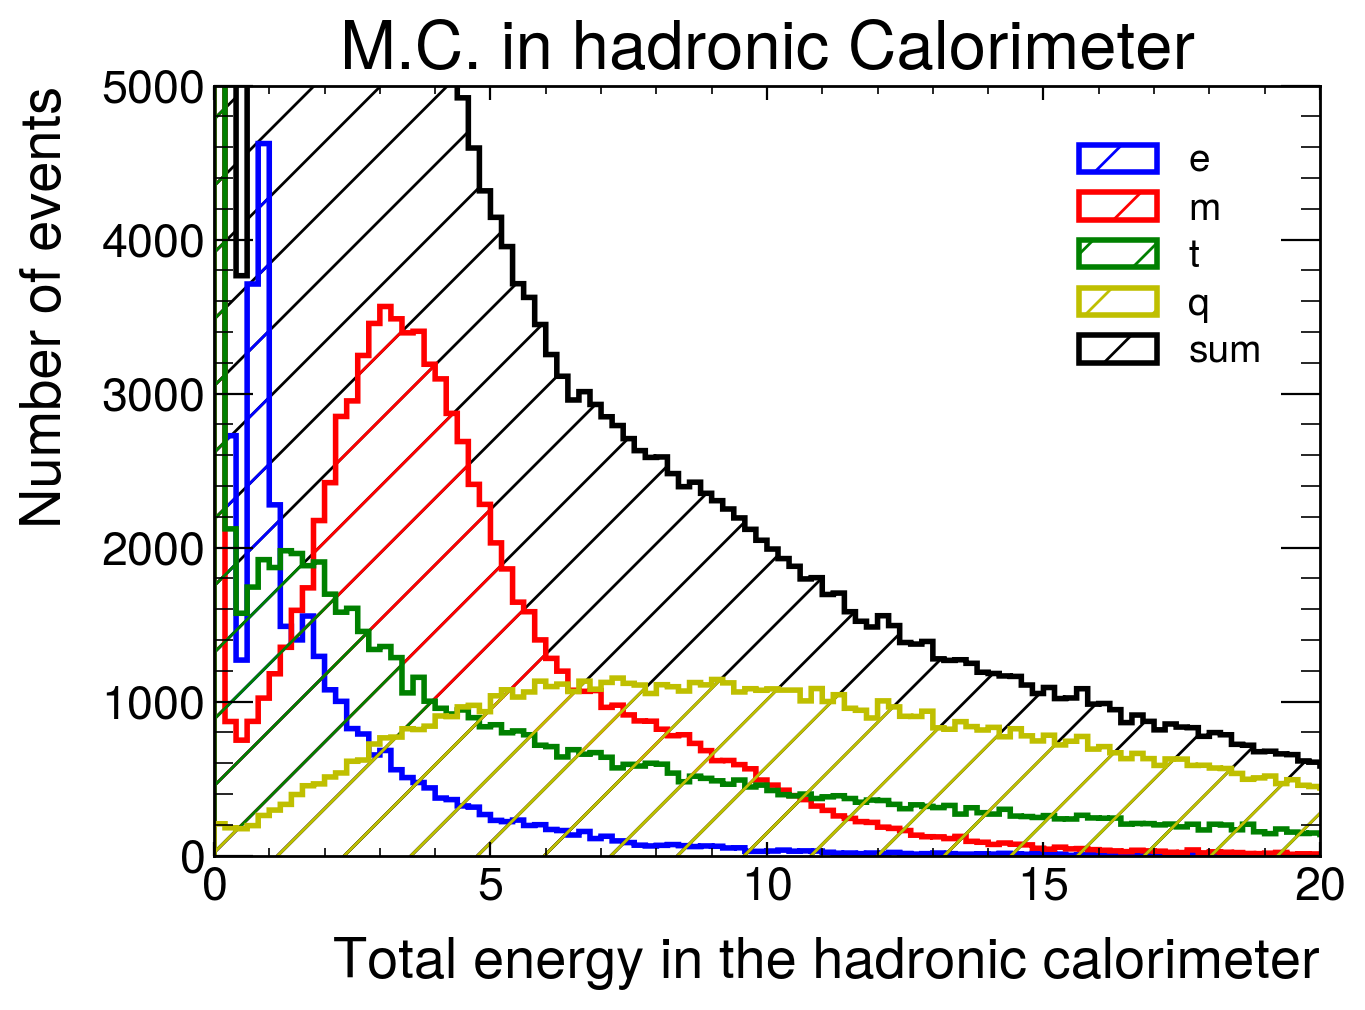

In [107]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(ehcal[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(ehcal[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(ehcal[2], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(ehcal[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')
bin_content, bin_edges, _ = plt.hist(ehcal[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title('M.C. in hadronic Calorimeter')
plt.xlim(0.,20.)
plt.ylim(0,5e3)
plt.xlabel('Total energy in the hadronic calorimeter')
plt.ylabel('Number of events')
plt.show()

In [108]:
def ellipsis(phi,a=3,b=10,x0=90.7,y0=89.3):
    r = a*b/np.sqrt((b*np.cos(phi))**2+(a*np.sin(phi))**2)
    return r
def pol2cart(rho, phi):
    x = rho * np.cos(phi)+90.7
    y = rho * np.sin(phi)+89.3
    return(x, y)

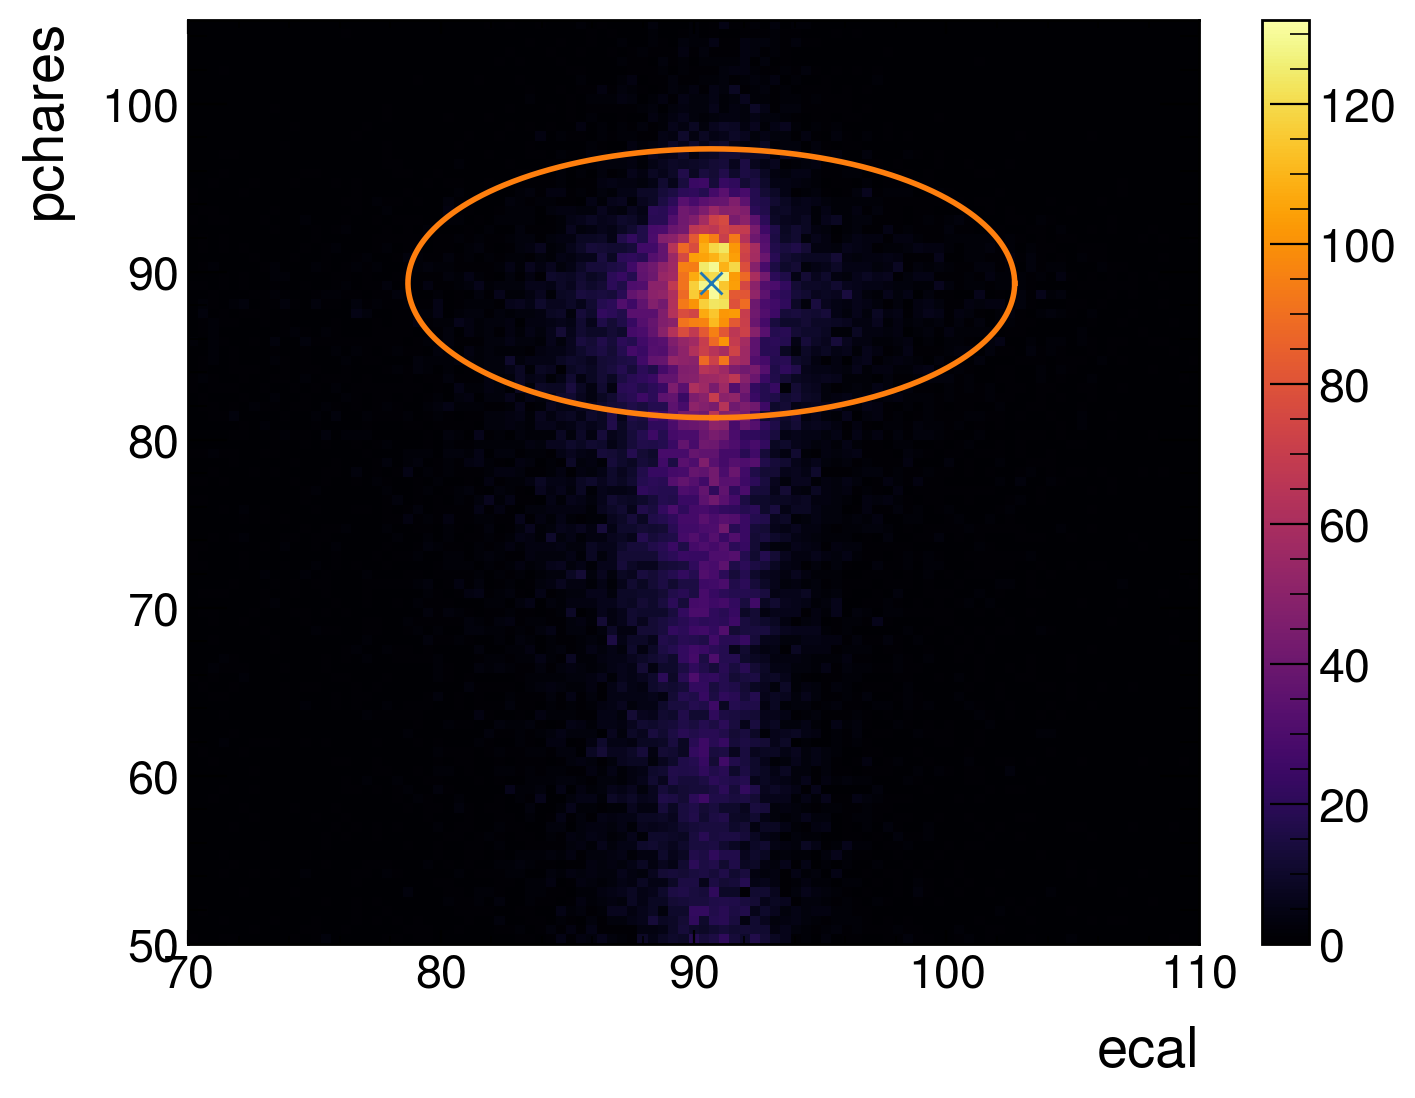

In [109]:
xedges = np.linspace(70,110,100)
yedges = np.linspace(50,105,100)
phi =np.linspace(0,2*np.pi,1000)
r = ellipsis(phi, b= 8, a = 12)
x ,y = pol2cart(r,phi)
plt.hist2d(eecal[0],pchares[0], bins=(xedges, yedges),cmap = 'inferno')
#plt.clim(0,20)
plt.colorbar()
plt.xlabel('ecal')
plt.ylabel('pchares')
plt.plot(90.7,89.3, marker = 'x')


plt.plot(x,y)


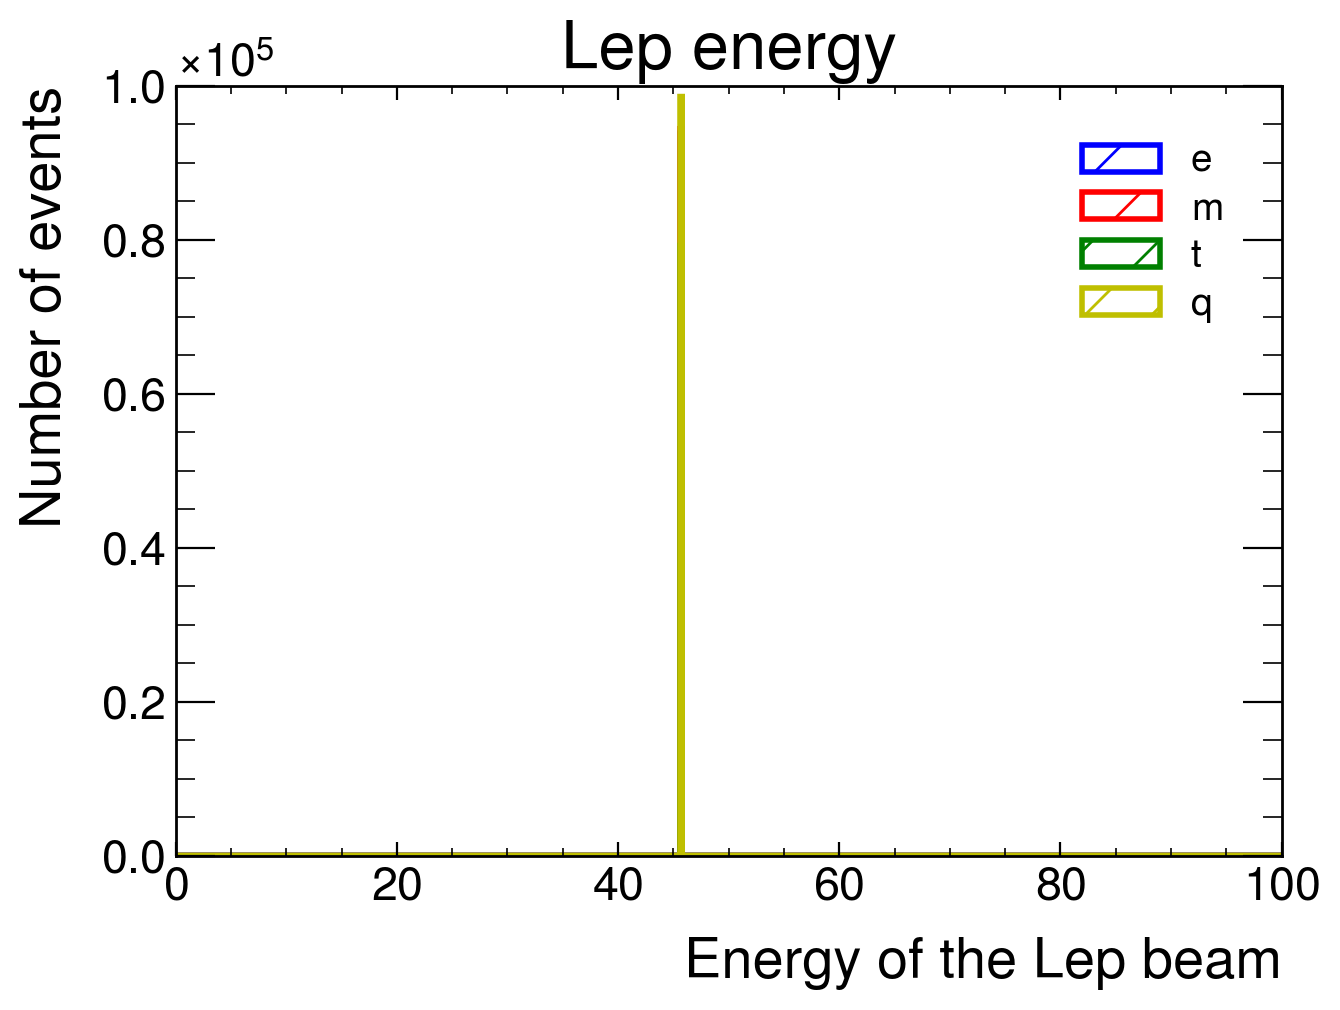

In [110]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(elep[0], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(elep[1], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(elep[2], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(elep[3], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title('Lep energy')
plt.xlim(0.,100.)
plt.ylim(0,1e5)
plt.xlabel('Energy of the Lep beam')
plt.ylabel('Number of events')
plt.show()

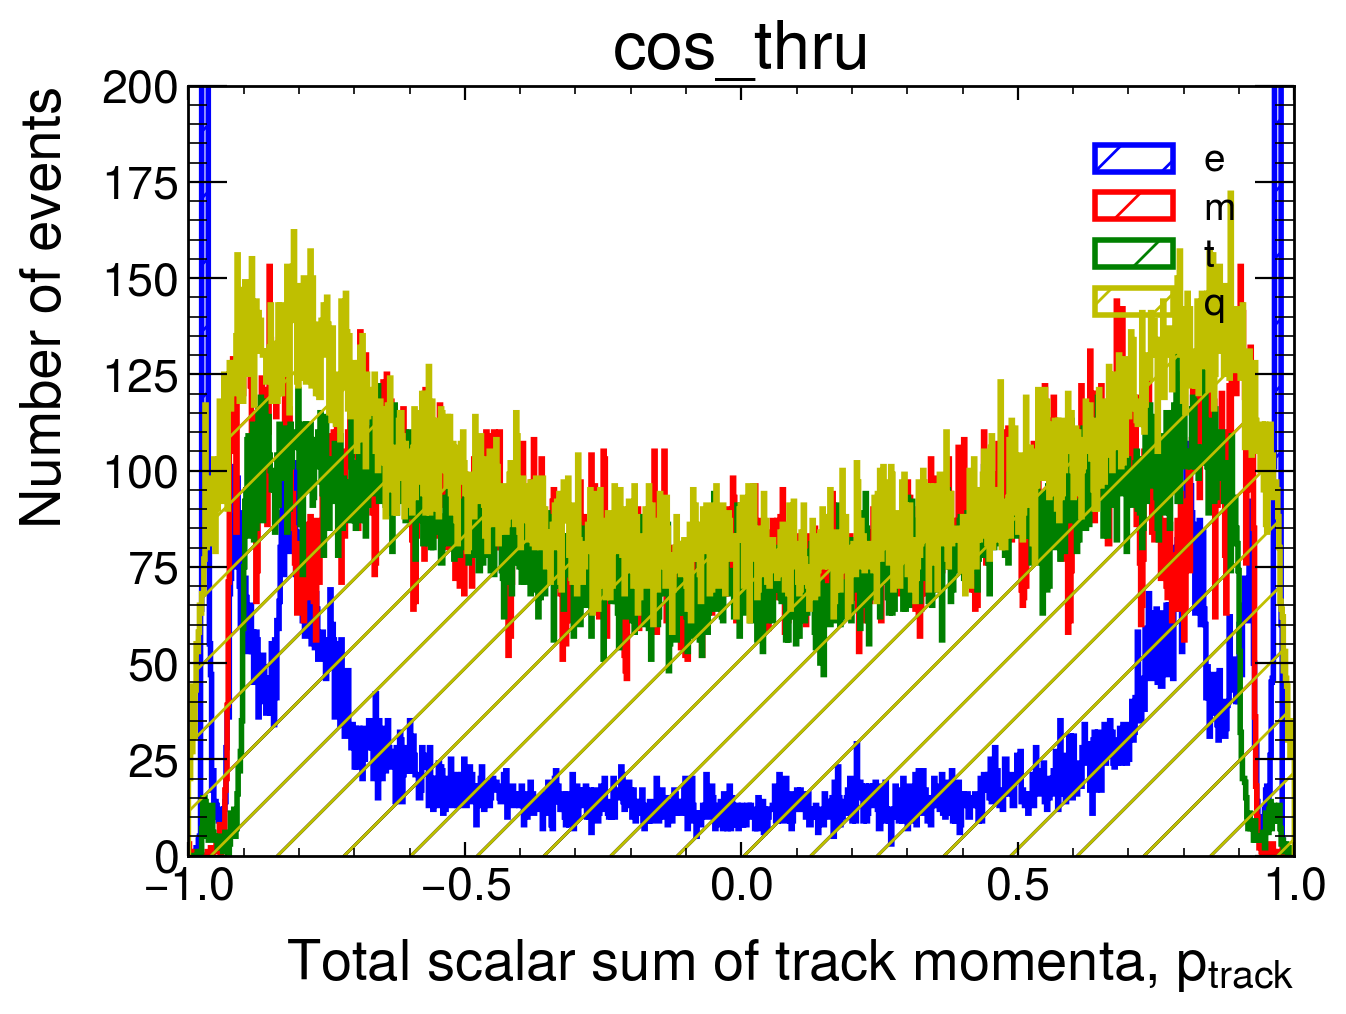

In [111]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(costhru[0], bins=1000, range=(-1,1), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(costhru[1], bins=1000, range=(-1,1.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(costhru[2], bins=1000, range=(-1,1.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(costhru[3], bins=1000, range=(-1,1.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')
#bin_content, bin_edges, _ = plt.hist(costhet[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[5])
plt.xlim(-1,1)
plt.ylim(0,2e2)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

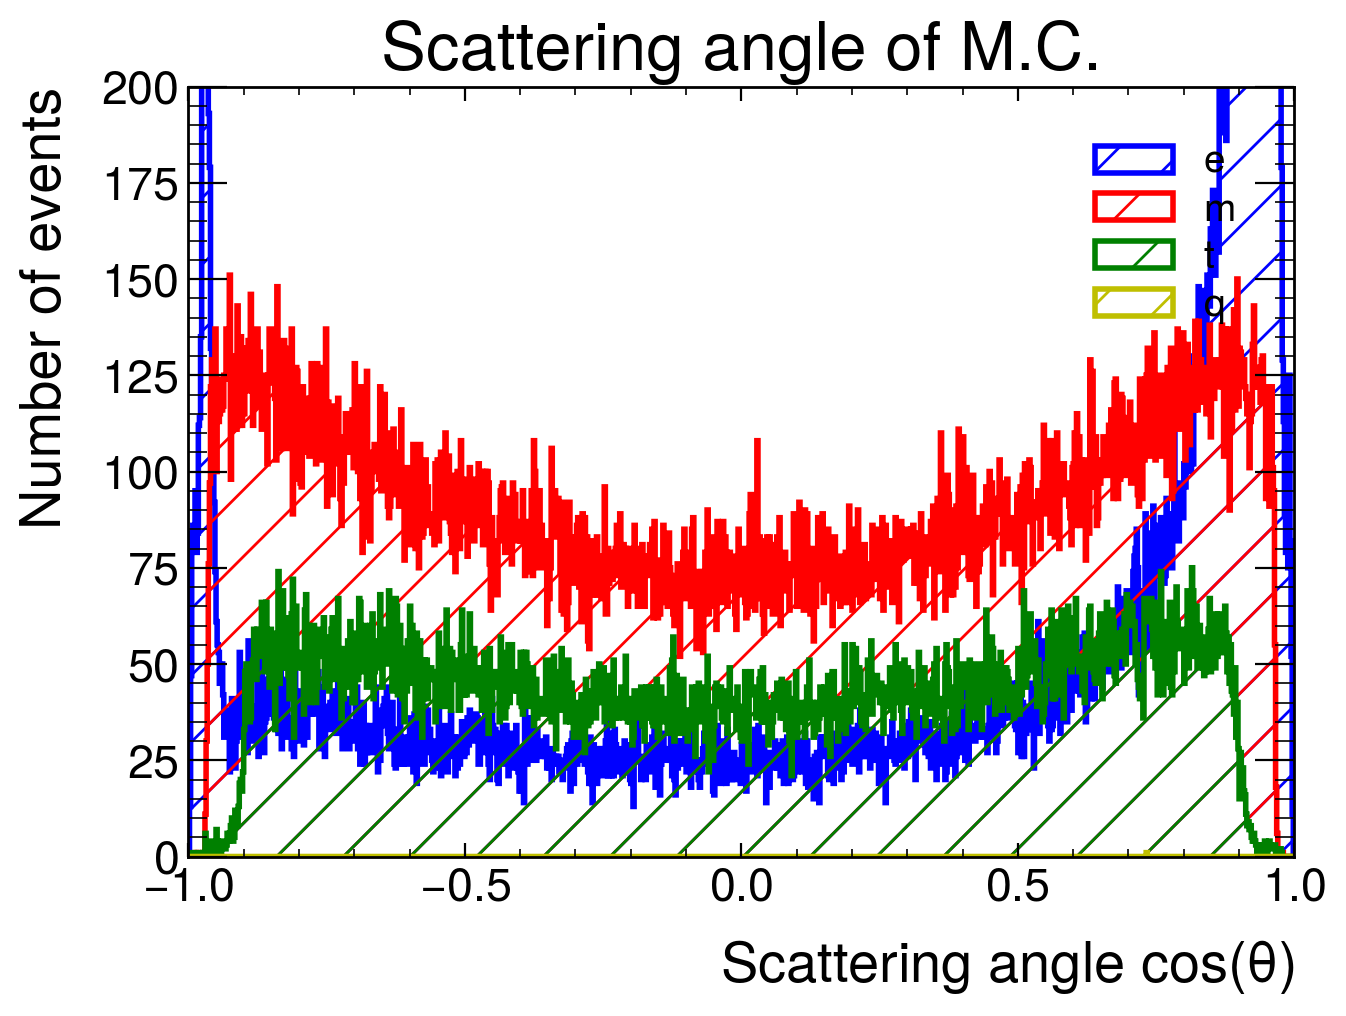

In [112]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')
x_min =-1
x_max = 1
bin_content, bin_edges, _ = plt.hist(costhet[0], bins=1000, range=(x_min,x_max), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(costhet[1], bins=1000, range=(x_min,x_max), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(costhet[2], bins=1000, range=(x_min,x_max), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(costhet[3], bins=1000, range=(x_min,x_max), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')
#bin_content, bin_edges, _ = plt.hist(costhet[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title('Scattering angle of M.C.')
plt.xlim(x_min,x_max)
plt.ylim(0,200)
plt.xlabel(r'Scattering angle $cos(\theta)$')
plt.ylabel('Number of events')
plt.show()

# Test Cuts
## Searchig ee

In [113]:
ecuts = [0] * 6
eeleptic = [0] * 6

i = 0
while i < 4:
    emasks = [0] * 6

    emasks[0] = brancheses[i]['E_ecal'] >= 50
    emasks[1] = brancheses[i]['E_ecal'] >= 68
    emasks[2] = brancheses[i]['Ncharged'] <= 6
    #emasks[3] = brancheses[i]['Pcharged'] >= 3

    # t cutting
    #emasks[3] = brancheses[i]['cos_thet'] <= .7
    #emasks[4] = brancheses[i]['cos_thet'] >= -.9
    # eleptic cuttig
    a = 12#4#4#3
    b = 8#8#15# 10
    #emasks[5] = np.logical_or( (((brancheses[i]['E_ecal']-90.7)**2/a**2 + (brancheses[i]['Pcharged']-89.3)**2/b**2) <= 1) , (brancheses[i]['Pcharged'] == 0))
    emasks[5] = ((brancheses[i]['E_ecal']-90.7)**2/a**2 + (brancheses[i]['Pcharged']-89.3)**2/b**2) <= 1
    eeleptic[i] = np.sum(emasks[5])
    
    ecuts[i] = emasks[0] & emasks[1] & emasks[2] #& emasks[3]# & emasks[5]# & emasks[3] & emasks[4] 
    i += 1


mcuts = [0] * 6
i = 0
while i < 4:
    mmasks = [0] * 4
    mmasks[0] = brancheses[i]['E_ecal'] <= 50
    mmasks[1] = np.logical_or(brancheses[i]['Pcharged'] >= 75, (brancheses[i]['Pcharged'] == 0))
    mmasks[2] = brancheses[i]['Ncharged'] ==2 #test to increase sigma (6 war davor)
    mmasks[3] = brancheses[i]['Pcharged'] > 6     #test to increase sigma
    mcuts[i] = mmasks[0] & mmasks[1] & mmasks[2] & mmasks[3]
    i += 1

tcuts = [0] * 6
i = 0
while i < 4:
    tmasks = [0] * 4
    tmasks[0] = brancheses[i]['E_ecal'] <= 70
    tmasks[1] = brancheses[i]['Pcharged'] <= 73
    tmasks[3] = brancheses[i]['Pcharged'] >= 3 #tauon optimierung
    tmasks[2] = brancheses[i]['Ncharged'] <= 7
    tcuts[i] =  tmasks[1] & tmasks[2] & tmasks[0] & tmasks[3]
    i += 1

qcuts = [0] * 6

i = 0
while i < 4:
    qmasks = [0] * 3
    qmasks[0] = brancheses[i]['Ncharged'] >= 8
    qmasks[1] = brancheses[i]['Ncharged'] >= 8
    qmasks[2] = brancheses[i]['Ncharged'] >= 8
    qcuts[i] = qmasks[0] & qmasks[1] & qmasks[2]
    i += 1

In [114]:
N = 100000
Ne = N#len(ecuts[1])#N#eeleptic[0] * (N / len(emasks[5]))
Nm = N#len(mcuts[1])
Nt = N#len(tcuts[1])
Nq = N#len(qcuts[1])
A = np.array([[np.sum(ecuts[0])/Ne, np.sum(ecuts[1])/Nm, np.sum(ecuts[2])/Nt, np.sum(ecuts[3])/Nq],
              [np.sum(mcuts[0])/Ne, np.sum(mcuts[1])/Nm, np.sum(mcuts[2])/Nt, np.sum(mcuts[3])/Nq],
              [np.sum(tcuts[0])/Ne, np.sum(tcuts[1])/Nm, np.sum(tcuts[2])/Nt, np.sum(tcuts[3])/Nq],
              [np.sum(qcuts[0])/Ne, np.sum(qcuts[1])/Nm, np.sum(qcuts[2])/Nt, np.sum(qcuts[3])/Nq]
             ])


k = np.array([[np.sum(ecuts[0]), np.sum(ecuts[1]), np.sum(ecuts[2]), np.sum(ecuts[3])],
              [np.sum(mcuts[0]), np.sum(mcuts[1]), np.sum(mcuts[2]), np.sum(mcuts[3])],
              [np.sum(tcuts[0]), np.sum(tcuts[1]), np.sum(tcuts[2]), np.sum(tcuts[3])],
              [np.sum(qcuts[0]), np.sum(qcuts[1]), np.sum(qcuts[2]), np.sum(qcuts[3])]
             ])

n = np.array([[Ne,Nm,Nt,Nq],
              [Ne,Nm,Nt,Nq],
              [Ne,Nm,Nt,Nq],
              [Ne,Nm,Nt,Nq]
              ])



#Bayesian Statistics: Variance (sqrt)
A_err = np.sqrt(((k+1)*(k+2)/((n+2)*(n+3))) - ((k+1)**2/(n+2)**2))
#A_err1 = np.sqrt(A*(1-A)/n)
#A_err =  np.sqrt(n)/N

print(np.array_repr(A, precision=7, suppress_small=True))
print(A_err)
#print(A_err1)

array([[0.92459, 0.00001, 0.01156, 0.00049],
       [0.00015, 0.84071, 0.00284, 0.     ],
       [0.00326, 0.03457, 0.75764, 0.00754],
       [0.00006, 0.     , 0.00544, 0.97548]])
[[8.35035633e-04 1.41416407e-05 3.38165137e-04 7.06912313e-05]
 [3.99958000e-05 1.15722652e-03 1.68574481e-04 9.99970001e-06]
 [1.80531004e-04 5.77776586e-04 1.35506006e-03 2.73726579e-04]
 [2.64559257e-05 9.99970001e-06 2.32809516e-04 4.89153297e-04]]


In [115]:
A_inv = np.linalg.inv(A)
print(A_inv)

# A*B_vec = F_mess_vec
# B_vec= A^-1 * F_mess_vec


[[ 1.08161858e+00  6.65727433e-04 -1.65027450e-02 -4.15756763e-04]
 [-1.77289998e-04  1.18965408e+00 -4.45693997e-03  3.45390981e-05]
 [-4.64553267e-03 -5.42880446e-02  1.32023571e+00 -1.02024654e-02]
 [-4.06214552e-05  3.02709455e-04 -7.36159848e-03  1.02519327e+00]]


# Analytical Error inversion

In [116]:
A_inv_err = np.zeros((4,4))

i = 0
while i < 4:
    j = 0
    while j < 4:
        m = 0
        while m < 4:
            n = 0
            while n < 4:
                A_inv_err[i,j] += (A_inv[i,m] * A_err[m,n] * A_inv[n,j])**2
                n += 1
            m += 4
        A_inv_err[i,j] =  np.sqrt((A_inv_err[i,j]))
        j += 1
    i += 1

print(A_inv_err)

[[9.76908626e-04 2.69401878e-05 4.83127241e-04 7.84769246e-05]
 [1.60126806e-07 4.41581342e-09 7.91902332e-08 1.28632903e-08]
 [4.19580527e-06 1.15707630e-07 2.07502295e-06 3.37057003e-07]
 [3.66889500e-08 1.01177037e-09 1.81444105e-08 2.94729300e-09]]


# Cutting in the sum of the MC data

In [117]:
i = 4
while i < 5:
    emasks = [0] * 6
    emasks[0] = brancheses[i]['E_ecal'] >= 50
    emasks[1] = brancheses[i]['E_ecal'] >= 68
    emasks[2] = brancheses[i]['Ncharged'] <= 6
    emasks[3] = brancheses[i]['Pcharged'] >= 3
    # t cutting
    #emasks[3] = brancheses[i]['cos_thet'] <= .7
    #emasks[4] = brancheses[i]['cos_thet'] >= -.9
    # eleptic cuttig
    a = 12#4#3
    b = 8#15# 10
    #emasks[5] = np.logical_or( (((brancheses[i]['E_ecal']-90.7)**2/a**2 + (brancheses[i]['Pcharged']-89.3)**2/b**2) <= 1) , (brancheses[i]['Pcharged'] == 0))
    emasks[5] =  ((brancheses[i]['E_ecal']-90.7)**2/a**2 + (brancheses[i]['Pcharged']-89.3)**2/b**2) <= 1
    eeleptic[i] = np.sum(emasks[5])
    
    ecuts[i] = emasks[0] & emasks[1] & emasks[2] & emasks[3]# & emasks[5]# & emasks[3] & emasks[4] 
    i += 1



i = 4
while i < 5:
    mmasks = [0] * 3
    mmasks[0] = brancheses[i]['E_ecal'] <= 50
    mmasks[1] = np.logical_or(brancheses[i]['Pcharged'] >= 75, (brancheses[i]['Pcharged'] == 0))
    mmasks[2] = brancheses[i]['Ncharged'] <= 6
    mcuts[i] = mmasks[0] & mmasks[1] & mmasks[2]
    i += 1


i = 4
while i < 5:
    tmasks = [0] * 4
    tmasks[0] = brancheses[i]['E_ecal'] <= 70
    tmasks[1] = brancheses[i]['Pcharged'] <= 73
    tmasks[3] = brancheses[i]['Pcharged'] >= 3 #tauon optimierung
    tmasks[2] = brancheses[i]['Ncharged'] <= 7
    tcuts[i] =  tmasks[1] & tmasks[2] & tmasks[0] & tmasks[3]
    i += 1


i = 4
while i < 5:
    qmasks = [0] * 3
    qmasks[0] = brancheses[i]['Ncharged'] >= 8
    qmasks[1] = brancheses[i]['Ncharged'] >= 8
    qmasks[2] = brancheses[i]['Ncharged'] >= 8
    qcuts[i] = qmasks[0] & qmasks[1] & qmasks[2]
    i += 1

In [118]:
B = A_inv.dot(np.array([np.sum(ecuts[4]), np.sum(mcuts[4]), np.sum(tcuts[4]), np.sum(qcuts[4])]) )
print(B)

[ 55060.19713757 108395.61782078  99810.2508167  100003.82234769]


In [119]:
#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')
x_min =-1
x_max = 1
Nbins = 1000

#bin_content, bin_edges, _ = plt.hist(costhet[4][ecuts[4]], bins=1000, range=(x_min,x_max), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e', zorder=2)
ye, bin_edges, = np.histogram(costhet[4][ecuts[4]], bins=Nbins, range=(x_min,x_max))
ym, bin_edges, = np.histogram(costhet[4][mcuts[4]], bins=Nbins, range=(x_min,x_max))
yt, bin_edges, = np.histogram(costhet[4][tcuts[4]], bins=Nbins, range=(x_min,x_max))
yq, bin_edges, = np.histogram(costhet[4][qcuts[4]], bins=Nbins, range=(x_min,x_max))

mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

E_costhet = np.zeros(Nbins)
M_costhet = np.zeros(Nbins)
T_costhet = np.zeros(Nbins)
Q_costhet = np.zeros(Nbins)

i = 0
while i < Nbins:
    multipi =  A_inv.dot(np.array([ye[i], ym[i], yt[i], yq[i]]))
    E_costhet[i] = multipi[0]
    M_costhet[i] = multipi[1]
    T_costhet[i] = multipi[2]
    Q_costhet[i] = multipi[3]
    i += 1

<ipython-input-119-fc593e905b94>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ye, bin_edges, = np.histogram(costhet[4][ecuts[4]], bins=Nbins, range=(x_min,x_max))
<ipython-input-119-fc593e905b94>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ym, bin_edges, = np.histogram(costhet[4][mcuts[4]], bins=Nbins, range=(x_min,x_max))
<ipython-input-119-fc593e905b94>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as 

# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

In [120]:
e_cut, bin_edges, = np.histogram(costhet[4][ecuts[4]], bins=Nbins, range=(-1,1))
mid = 0.5*(bin_edges[1:] + bin_edges[:-1])

<ipython-input-120-c75093ba9b0b>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  e_cut, bin_edges, = np.histogram(costhet[4][ecuts[4]], bins=Nbins, range=(-1,1))


In [121]:
def dsigdtheta(theta,A,B):
    y = A*(1+theta**2)+B*(1-theta)**(-2)
    return y
def sdsig(theta,A):
    return A*(1+theta**2)
def tdsig(theta,B):
    return B*(1-theta)**(-2)

31479.32477868259


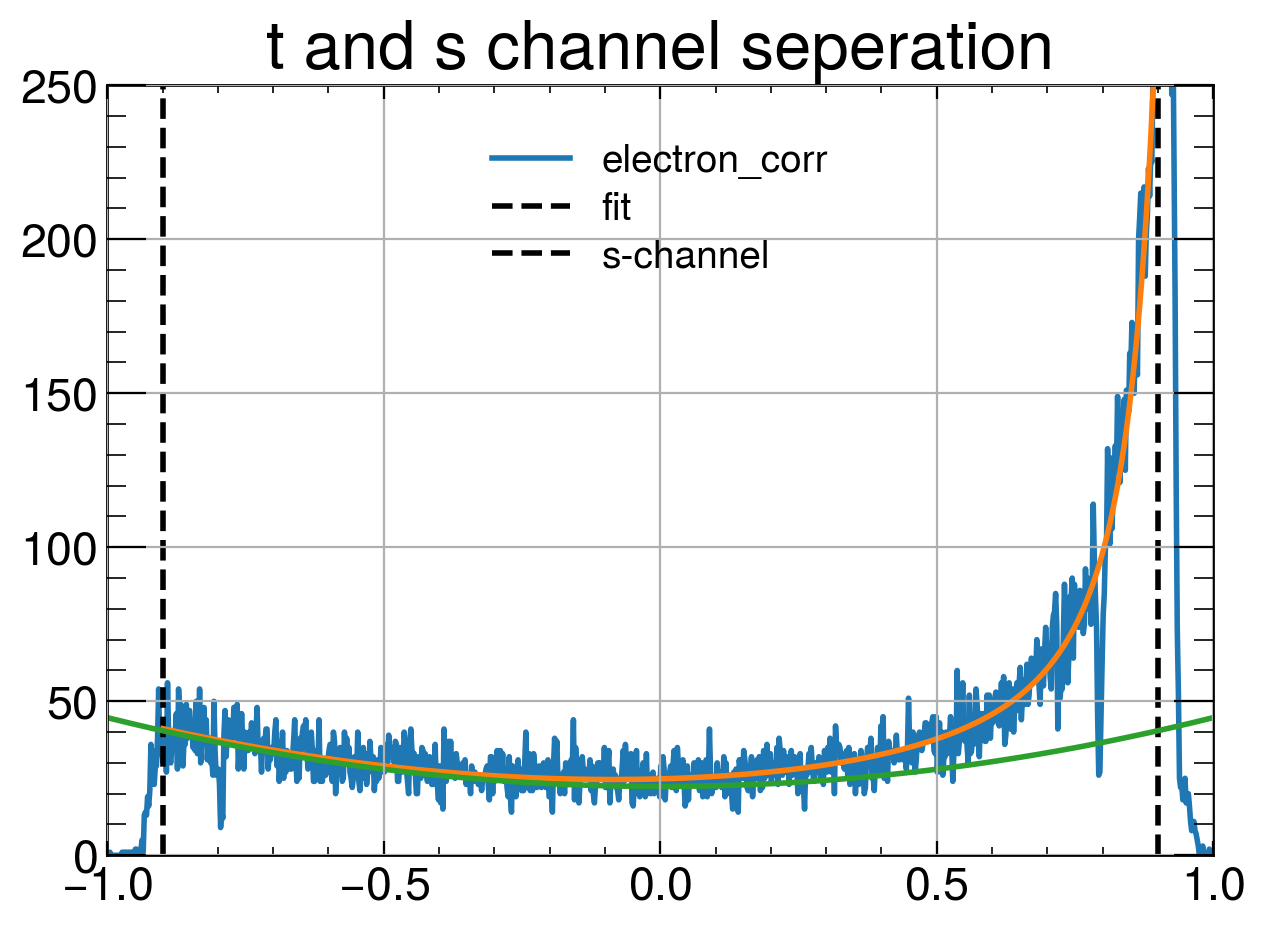

In [122]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

# Subtracting t channel
bin_min = 50
bin_max = 950
x_min = mid[bin_min]
x_max = mid[bin_max]
x_min_e_cut = x_min
x_max_e_cut = x_max

coeff, var_matrix  =curve_fit(dsigdtheta,mid[bin_min:bin_max],e_cut[bin_min:bin_max])
hist_fit = dsigdtheta(mid[bin_min:bin_max],*coeff)
#fit_t_chan = tdsig(mid[bin_min:bin_max],coeff[1])
fit_s_chan = sdsig(mid,coeff[0])



# ratio s/ges
ratio_s = sum(fit_s_chan)/np.sum(ecuts[4])
e_schannel_corr = B[0]*ratio_s

print(e_schannel_corr)


plt.title('t and s channel seperation')
plt.plot(mid, e_cut, label = 'electron_corr')
plt.axvline(x=0.9, color = 'k', ls = '--', label = 'fit')
plt.axvline(x=-0.9, color = 'k', ls = '--', label = 's-channel')
plt.plot(mid[bin_min:bin_max],hist_fit)
plt.plot(mid,fit_s_chan)
plt.grid()

#E_s_chan = E_costhet[bin_min:bin_max] - fit_t_chan
#plt.plot(mid[bin_min:bin_max],E_s_chan)
plt.ylim(0,250)
plt.legend()
plt.show()

# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [123]:
xs_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                      'hadronic' : [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],

                      'leptonic' : [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]}

In [124]:
data_nr = 6
path_opal = 'opal_data/data/daten_' +str(data_nr) +'.root'
data = uproot.open(path_opal)


branchesopal = data[ttree_name].arrays()


ncharesopal = ak.to_numpy(branchesopal[var[0]]) #copy from strange array to nomal array.
pcharesopal = ak.to_numpy(branchesopal[var[1]])
eecalopal = ak.to_numpy(branchesopal[var[2]])
ehcalopal = ak.to_numpy(branchesopal[var[3]])
elepopal = ak.to_numpy(branchesopal[var[4]])
costhruopal = ak.to_numpy(branchesopal[var[5]])
costhetopal = ak.to_numpy(branchesopal[var[6]])
runopal = ak.to_numpy(branchesopal[var[7]])
eventopal = ak.to_numpy(branchesopal[var[8]])

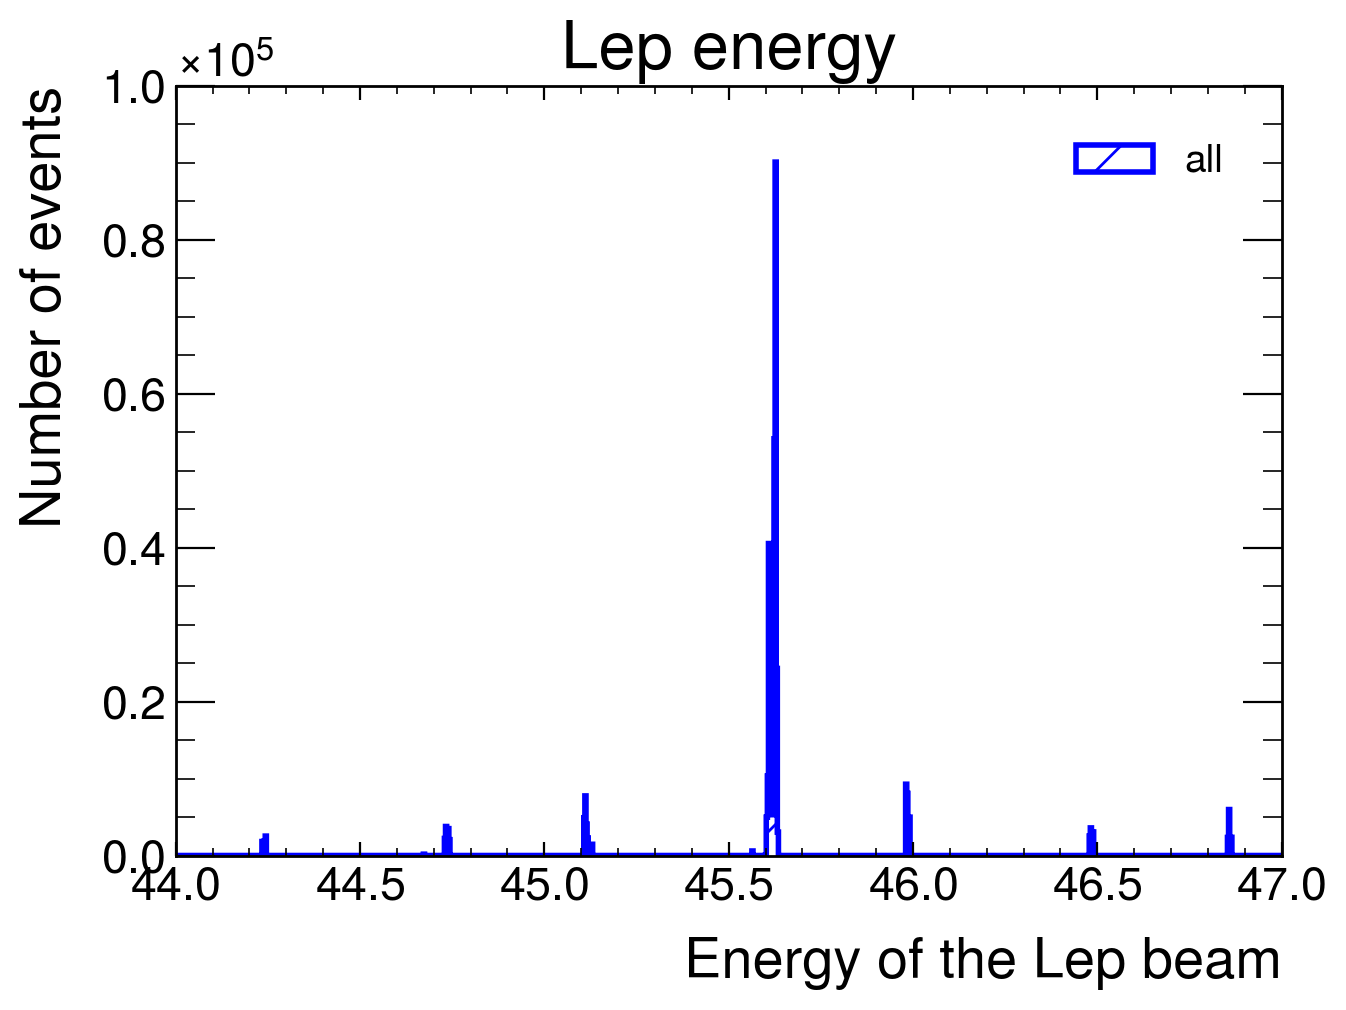

In [125]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(elepopal, bins=1000, range=(44.,47.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='all')

mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

### Show the plot on screen
plt.legend()
plt.title('Lep energy')
plt.xlim(44.,47)
plt.xlabel('Energy of the Lep beam')
plt.ylabel('Number of events')
plt.show()

In [126]:
ncharesopal = ak.to_numpy(branchesopal[var[0]]) #copy from strange array to nomal array.
pcharesopal = ak.to_numpy(branchesopal[var[1]])
eecalopal = ak.to_numpy(branchesopal[var[2]])
ehcalopal = ak.to_numpy(branchesopal[var[3]])
elepopal = ak.to_numpy(branchesopal[var[4]])
costhruopal = ak.to_numpy(branchesopal[var[5]])
costhetopal = ak.to_numpy(branchesopal[var[6]])
runopal = ak.to_numpy(branchesopal[var[7]])
eventopal = ak.to_numpy(branchesopal[var[8]])

In [127]:
opalEcuts = [0] * 7
opalMcuts = [0] * 7
opalTcuts = [0] * 7
opalQcuts = [0] * 7

EnergyCutsUP = [44.4, 44.9, 45.2, 45.8, 46.1, 46.6, 47.0]
EnergyCutsLP = [44.0, 44.6, 45.0, 45.4, 45.9, 46.4, 46.8]

i = 0
while i < 7:
    emasks = [0] * 8
    emasks[0] = branchesopal['E_ecal'] >= 50
    emasks[1] = branchesopal['E_ecal'] >= 68
    emasks[2] = branchesopal['Ncharged'] <= 6
    #emasks[3] = branchesopal['Pcharged'] >=3
    # t cutting
    #emasks[3] = branchesopal['cos_thet'] <= .7
    #emasks[4] = branchesopal['cos_thet'] >= -.9
 
    
    #Energy
    emasks[6] = branchesopal['E_lep'] >= EnergyCutsLP[i]
    emasks[7] = branchesopal['E_lep'] <= EnergyCutsUP[i]
    opalEcuts[i] = emasks[0] & emasks[1] & emasks[2] & emasks[6] & emasks[7] #& emasks[3]# & emasks[5]# & emasks[3] & emasks[4] 
    i += 1



i = 0
while i < 7:
    mmasks = [0] * 7
    mmasks[0] = branchesopal['E_ecal'] <= 20
    mmasks[1] = branchesopal['Pcharged'] >= 75
    #np.logical_or(branchesopal['Pcharged'] >= 75, (branchesopal['Pcharged'] == 0))
    mmasks[2] = branchesopal['Ncharged'] <=2
    #Energy
    mmasks[3] = branchesopal['E_lep'] >= EnergyCutsLP[i]
    mmasks[4] = branchesopal['E_lep'] <= EnergyCutsUP[i]
    
    opalMcuts[i] = mmasks[0] & mmasks[1] & mmasks[2] & mmasks[3] & mmasks[4] #& mmasks[5] #& mmasks[6]
    i += 1


i = 0
while i < 7:

    tmasks = [0] * 6
    tmasks[0] = branchesopal['E_ecal'] <= 70
    tmasks[1] = branchesopal['Pcharged'] <= 73
    tmasks[5] = branchesopal['Pcharged'] >= 3 #tauon optimierung
    tmasks[2] = branchesopal['Ncharged'] <= 7
    #Energy
    tmasks[3] = branchesopal['E_lep'] >= EnergyCutsLP[i]
    tmasks[4] = branchesopal['E_lep'] <= EnergyCutsUP[i]

    opalTcuts[i] =  tmasks[1] & tmasks[2] & tmasks[0] & tmasks[3] & tmasks[4] & tmasks[5]
    i += 1


i = 0
while i < 7:
    qmasks = [0] * 5
    qmasks[0] = branchesopal['Ncharged'] >= 8
    qmasks[1] = branchesopal['Ncharged'] >= 8
    qmasks[2] = branchesopal['Ncharged'] >= 8
    #Energy
    qmasks[3] = branchesopal['E_lep'] >= EnergyCutsLP[i]
    qmasks[4] = branchesopal['E_lep'] <= EnergyCutsUP[i]
    opalQcuts[i] = qmasks[0] & qmasks[1] & qmasks[2] & qmasks[3] & qmasks[4]
    i += 1


In [128]:
opalB = [0] * 7
f = [0] * 7
f_err = [0] * 7
i = 0
while i < 7:
    f[i] = np.array([np.sum(opalEcuts[i]), np.sum(opalMcuts[i]), np.sum(opalTcuts[i]), np.sum(opalQcuts[i])])
    f_err[i] = np.array([np.sqrt(f[i][0]), np.sqrt(f[i][1]), np.sqrt(f[i][2]), np.sqrt(f[i][3])])
    opalB[i] = A_inv.dot(f[i])
    i += 1
print(opalB)


opalB_err = [0] * 7
k = 0
while k < 7:
    opalB_err[k] = [0] * 4
    i = 0
    while i < 4:
        j = 0
        while j < 4:
            opalB_err[k][i] += (A_inv[i,j]**2 * f_err[k][j]**2 + A_inv_err[i,j]**2 * f[k][j]**2)
            j += 1
        opalB_err[k][i] = np.sqrt(opalB_err[k][i])
        i += 1
    k += 1

[array([2320.74898142,  152.30129743,  215.02249787, 3615.3391486 ]), array([3028.55128687,  398.89250799,  419.99891441, 8107.32510439]), array([ 3424.58145245,   777.10853982,   761.75784222, 16025.59823108]), array([ 32660.75278068,  11485.09567544,  11783.83865687, 240527.67486011]), array([ 2839.37842157,  1017.8157113 ,  1016.28401067, 20368.74262135]), array([1673.31499871,  396.55418689,  479.55362407, 8820.57123609]), array([2461.44688257,  445.17532485,  481.49141219, 9388.43748709])]


# Import Luminosities 

In [129]:
import csv
lumi_data = 'opal_data/lumi_files/daten_' +str(data_nr) +'.lum'
#opal_data/data/daten_1.root'

energy = np.zeros(7)
lumi = np.zeros(7)
err_stat_lumi = np.zeros(7)
err_sys_lumi = np.zeros(7)
err_all_lumi = np.zeros(7)

with open(lumi_data, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for jj,row in enumerate(spamreader):
        if jj >0:
            energy[jj-1] = float(row[0])
            lumi[jj-1] = float(row[1])
            err_stat_lumi[jj-1] = float(row[2])
            err_sys_lumi[jj-1] = float(row[3])
            err_all_lumi[jj-1] = float(row[4])

# t and s seperation for electron

In [130]:
opal_e_cut_E = []
opal_e_cut_mid = []
Nbins_opal = 100
for i in range(7):
    E, bin_edge, = np.histogram(costhetopal[opalEcuts[i]], bins=Nbins_opal, range=(-1,1))
    mid = 0.5*(bin_edge[1:] + bin_edge[:-1])

    opal_e_cut_E.append(E)
    opal_e_cut_mid.append(mid)
    

100


80
900
Fit number: 0
[0.99677382 0.864659  ]


Fit number: 1
[3.31564432 0.74263123]


Fit number: 2
[5.55227438 0.82700747]


Fit number: 3
[72.51082571  5.81647295]


Fit number: 4
[6.06831245 0.2802359 ]


Fit number: 5
[2.03012375 0.30542095]


Fit number: 6
[2.47873573 0.36255815]


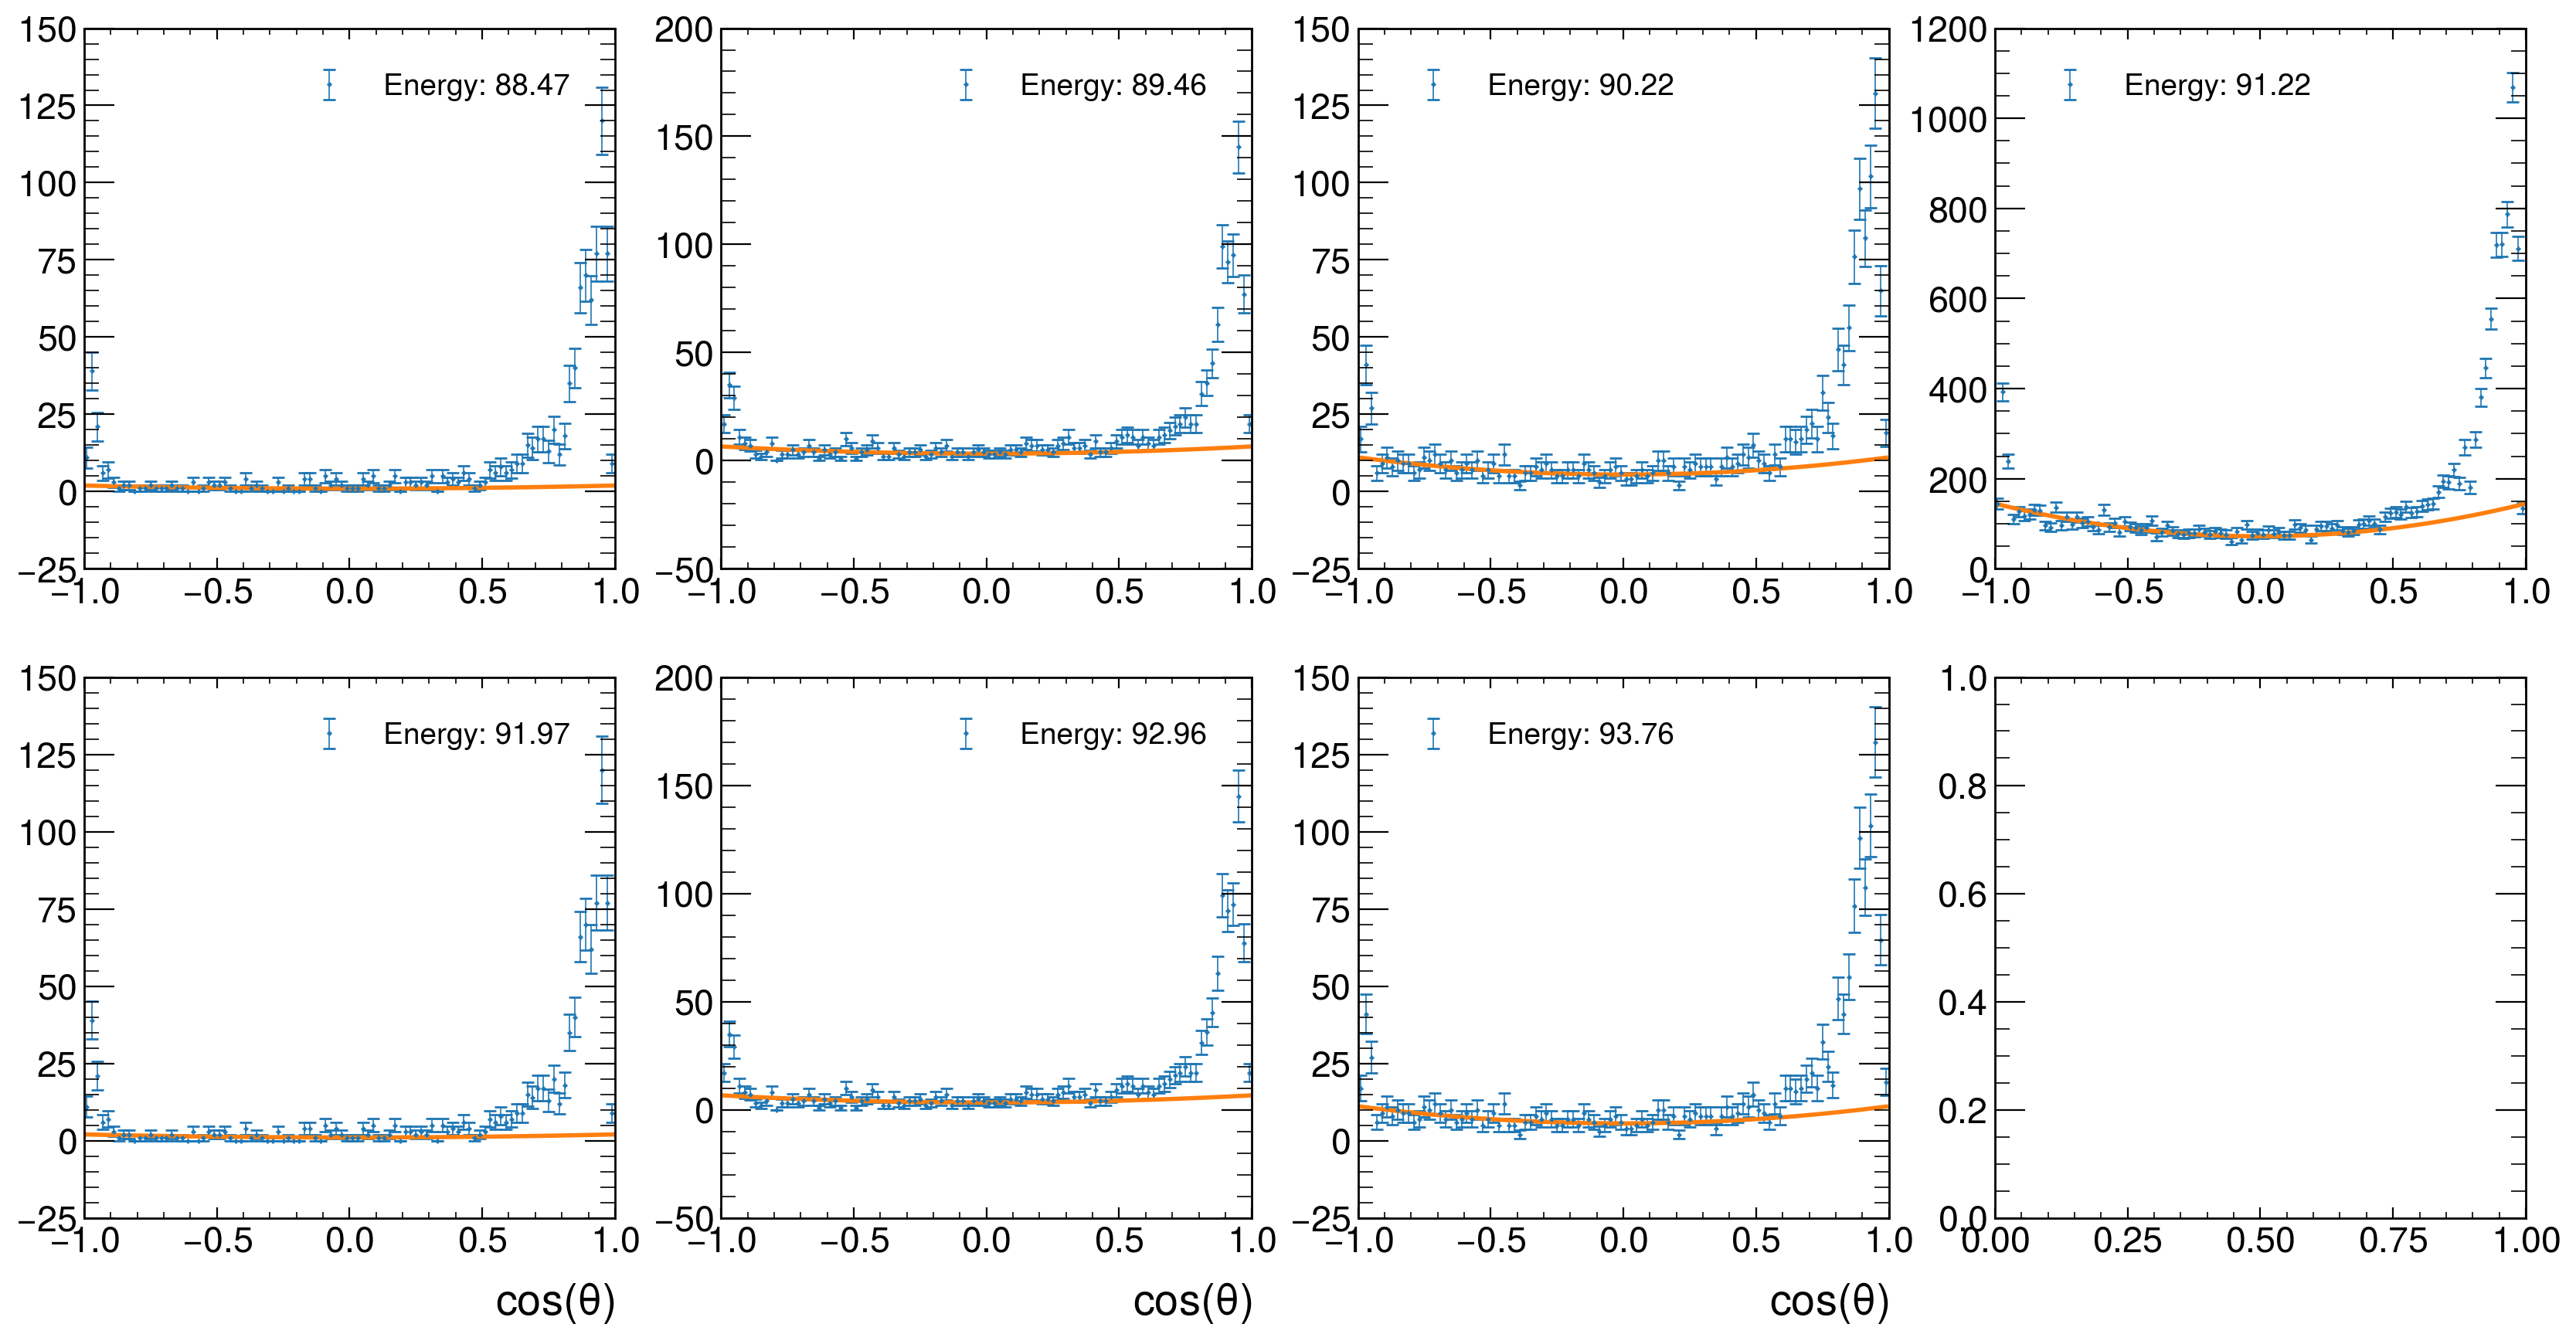

[0.061815430537826004, 0.15738195399205757, 0.23258034887953416, 0.31748686769361106, 0.3763294543059676, 0.09636282186038944, 0.10383226417075538]
[0.0032667168446602534, 0.0031791312795741954, 0.003848501599609052, 0.01157785226223944, 0.005791611916563177, 0.0019193535252179342, 0.001483699205642034]


In [153]:
# Fitting
# Subtracting t channel
print(bin_min)
print(bin_max)
bin_min_opal = int(bin_min/1000*Nbins_opal)
bin_max_opal = int(bin_max/1000*Nbins_opal)

x_min = mid[bin_min_opal]
x_max = mid[bin_max_opal]

fit_s_chan = []
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
energy = xs_corrections['energy']
ratio_s_opal = []
ratio_s_opal_err = []
#ratio_s_opal_analy = []
for ii in range(7):
    coeff, var_matrix = curve_fit(dsigdtheta, opal_e_cut_mid[ii][bin_min_opal:bin_max_opal],opal_e_cut_E[ii][bin_min_opal:bin_max_opal])
    print('Fit number:',ii)
    print(coeff)
    hist_fit = dsigdtheta(mid[bin_min_opal:bin_max_opal], *coeff)
    fit_s_chan.append( sdsig(mid, coeff[0]))
    jj = ii
    line = 0 #line number
    if ii>3: #go into the second line
        line = 1 #second line
        ii = ii-4 #column number
    
    error_sizes = np.sqrt(opal_e_cut_E[ii])
    #error_sizes = np.sqrt(np.zeros(len(opal_e_cut_E[ii])))

    im = ax[line,ii].errorbar(opal_e_cut_mid[ii], opal_e_cut_E[ii], yerr=error_sizes, label = 'Energy: {}'.format(energy[jj]), fmt="+", ms=2, elinewidth=0.6, capsize=3, mew=1)
    #im = ax[line,ii].plot(opal_e_cut_mid[ii],opal_e_cut_E[ii],label = 'Energy: {}'.format(energy[jj]))
    im = ax[line,ii].plot(opal_e_cut_mid[ii],fit_s_chan[ii])
    im = ax[line,ii].legend()
    
    #ratio_s_opal.append( sum(fit_s_chan[ii]) / sum(opalEcuts[ii]))
    ratio_s_opal.append(coeff[0] * (8 / 3) * len(fit_s_chan[ii]) / (sum(opalEcuts[ii])*2) )
    ratio_s_opal_err.append(np.sqrt(((8 / 3) * len(fit_s_chan[ii]) / (sum(opalEcuts[ii])*2))**2) * var_matrix[0][0] + (coeff[0] * (8 / 3) * len(fit_s_chan[ii]) / (sum(opalEcuts[ii])*2)**2 )**2 * opalB_err[ii][0]**2)
    
ax[1,0].set_xlabel(r'$cos(\theta)$')
ax[1,1].set_xlabel(r'$cos(\theta)$')
ax[1,2].set_xlabel(r'$cos(\theta)$')
plt.show()
    
print(ratio_s_opal)
print(ratio_s_opal_err)
#print(ratio_s_opal_analy)

In [133]:
# apply s channel correction
for ii in range(7):

    opalB[ii][0] = opalB[ii][0] * ratio_s_opal[ii]
    opalB_err[ii][0] = np.sqrt(ratio_s_opal[ii]**2 * opalB_err[ii][0]**2 + opalB[ii][0]**2 * ratio_s_opal_err[ii]**2)

# Calculate cross section

In [134]:
Sigma = [0] * 7
Sigma_err = [0] * 7
i = 0
while i < 7:
    Sigma[i] = opalB[i] / lumi[i]
    #Sigma_err[i] = np.sqrt((1 / lumi[i])**2 * opalB_err[i]**2 + (opalB[i] / lumi[i]**2)**2 * err_all_lumi[i]**2)
    Sigma_err[i] = [0] * 4
    k = 0
    while k < 4:
        Sigma_err[i][k] = np.sqrt((1 / lumi[i])**2 * opalB_err[i][k]**2 + (opalB[i][k] / lumi[i]**2)**2 * err_all_lumi[i]**2)
        k += 1
    Sigma_err[i] = np.array(Sigma_err[i])
    i += 1
print(Sigma)
print(Sigma_err)

[array([0.21226039, 0.22534478, 0.31814698, 5.34925058]), array([ 0.59517154,  0.4980904 ,  0.52444562, 10.12348117]), array([ 0.91162691,  0.88944337,  0.87187365, 18.34217662]), array([ 1.31365842,  1.45500711,  1.49285382, 30.47162042]), array([ 1.2947658 ,  1.23330043,  1.23144445, 24.68106822]), array([ 0.25816192,  0.6349032 ,  0.76778947, 14.12217813]), array([0.27124815, 0.47247091, 0.5110137 , 9.96408246])]
[array([0.00497882, 0.02008317, 0.02799299, 0.10083706]), array([0.01244665, 0.02757823, 0.03341995, 0.14120433]), array([0.0182275 , 0.03562039, 0.0416631 , 0.20947499]), array([0.01930532, 0.01789987, 0.02051645, 0.21888194]), array([0.02860294, 0.04347289, 0.05087926, 0.26958118]), array([0.00698877, 0.03530758, 0.04535161, 0.19661585]), array([0.00613411, 0.02478579, 0.03034799, 0.13222373])]


In [135]:
# apply ratiation correction
Sigma_corr = np.zeros((4,7))
Sigma_corr_err = np.zeros((4,7))

for ii in range(7):
    Sigma_corr[0,ii] = Sigma[ii][0] + xs_corrections['leptonic'][ii]
    Sigma_corr[1,ii] = Sigma[ii][1] + xs_corrections['leptonic'][ii]
    Sigma_corr[2,ii] = Sigma[ii][2] + xs_corrections['leptonic'][ii]
    Sigma_corr[3,ii] = Sigma[ii][3] + xs_corrections['hadronic'][ii]
    Sigma_corr_err[0,ii] = Sigma_err[ii][0]
    Sigma_corr_err[1,ii] = Sigma_err[ii][1]
    Sigma_corr_err[2,ii] = Sigma_err[ii][2]
    Sigma_corr_err[3,ii] = Sigma_err[ii][3]

# Plot and fit of Sigmas

In [136]:
def relativistic_breit_wigner(x, resonance_mass, width, normalization):
    gamma = np.sqrt(resonance_mass**2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)

In [137]:
def relativistic_breit_wigner_normalized(x, resonance_mass, width, A):
    gamma = np.sqrt(resonance_mass**2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return A * (resonance_mass**2 * width**2/k) *k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)

In [138]:
listE = np.linspace(energy[0],energy[-1],1000)
bounds = [[90,0,1],[92,4,7000]]
coeff = np.zeros((4,3))
#coeff[0,:], var_matrix_e  = curve_fit(relativistic_breit_wigner,energy,Sigma_corr[0],p0 = [91,1,2] )#)#, bounds = bounds)
coeff[0,:], var_matrix_e  = curve_fit(relativistic_breit_wigner_normalized,energy, Sigma_corr[0], p0 = [91,1,2] )
#coeff[0,:], var_matrix_m  = curve_fit(breit_wigner,energy,Sigma_corr[0],p0 = [ 91, 2, 6], maxfev = 10000, bounds = bounds) #
coeff[1,:], var_matrix_m  = curve_fit(relativistic_breit_wigner_normalized, energy,Sigma_corr[1], p0 = [91,1,1000], bounds = bounds)
coeff[2,:], var_matrix_t  = curve_fit(relativistic_breit_wigner_normalized, energy,Sigma_corr[2], p0 = [91,2,3], bounds = bounds)
coeff[3,:], var_matrix_h  = curve_fit(relativistic_breit_wigner_normalized, energy,Sigma_corr[3], p0 = [91,1,1000], bounds = bounds)
fit_sigma = np.zeros((4,len(listE)))
for i in range(4):
    fit_sigma[i,:] = relativistic_breit_wigner_normalized(listE, *coeff[i,:])
print(coeff)
#fit_sigma[0,:] = relativistic_breit_wigner_normalized(listE, *coeff[0,:])

[[91.10149294  2.37436055  1.94913989]
 [91.19688309  2.49748114  1.98787105]
 [91.22296282  2.64922654  1.9797122 ]
 [91.1884641   2.53226233 41.13645983]]


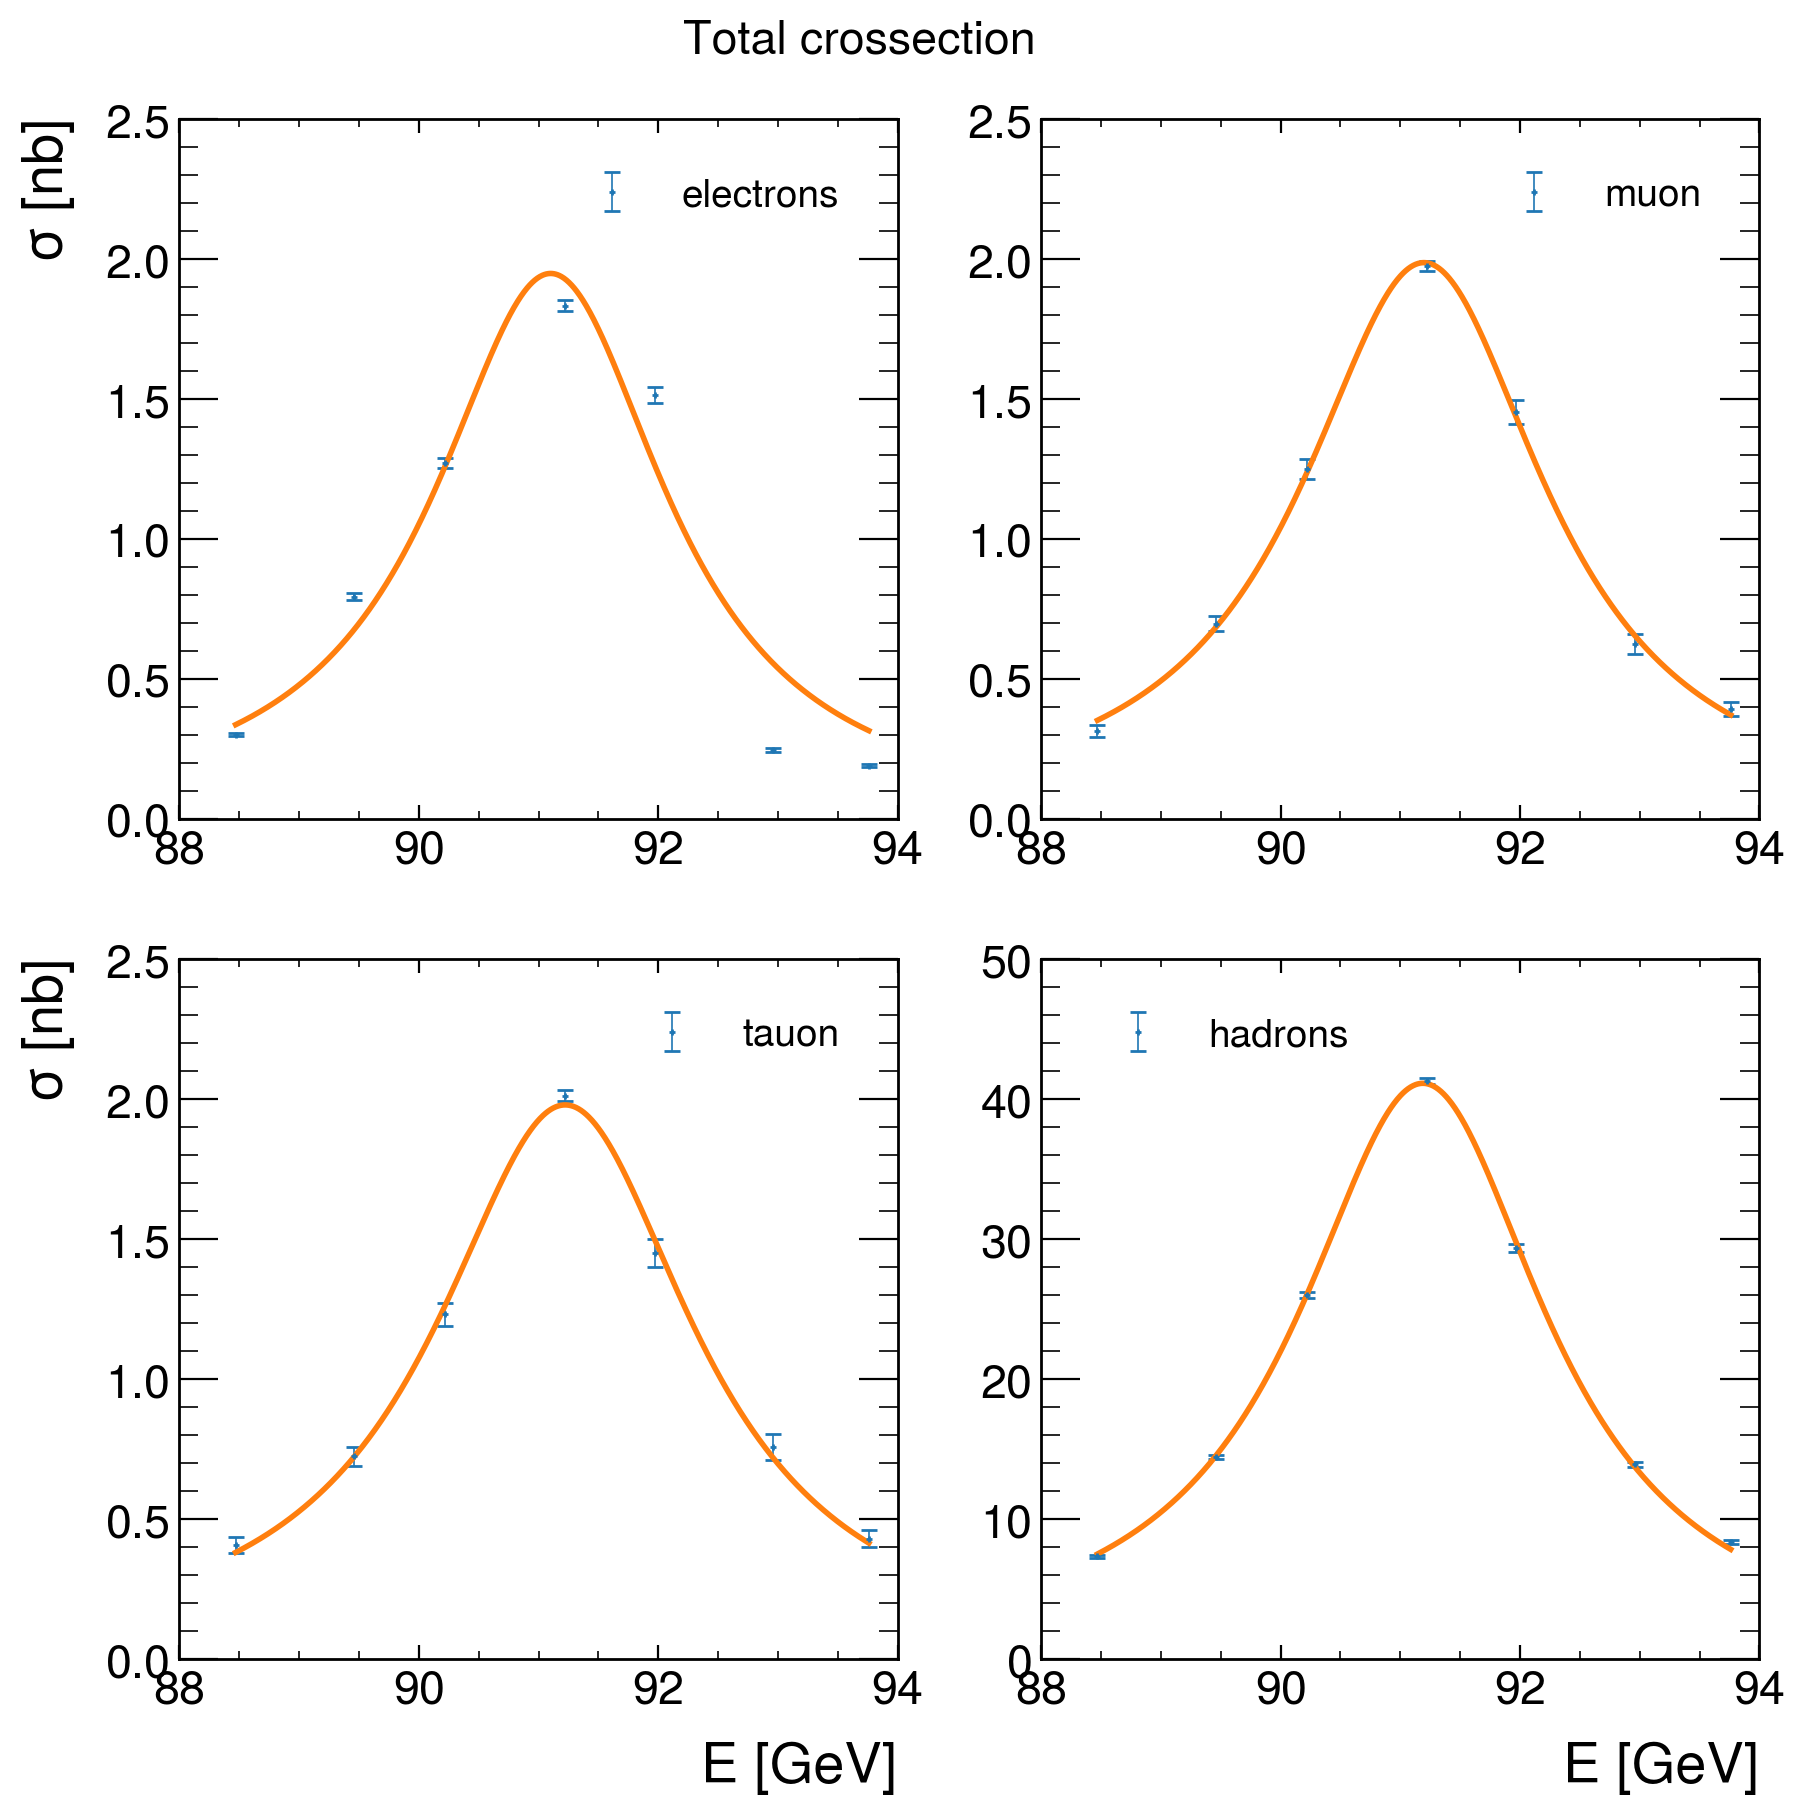

In [139]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

fig.suptitle('Total crossection')
ax[0,0].errorbar(energy, Sigma_corr[0], yerr=Sigma_corr_err[0], label = 'electrons', fmt="+", ms=2, elinewidth=0.6, capsize=3, mew=1)
ax[0,1].errorbar(energy, Sigma_corr[1], yerr=Sigma_corr_err[1], label = 'muon', fmt="+", ms=2, elinewidth=0.6, capsize=3, mew=1)
ax[1,0].errorbar(energy, Sigma_corr[2], yerr=Sigma_corr_err[2], label = 'tauon', fmt="+", ms=2, elinewidth=0.6, capsize=3, mew=1)
ax[1,1].errorbar(energy, Sigma_corr[3], yerr=Sigma_corr_err[3], label = 'hadrons', fmt="+", ms=2, elinewidth=0.6, capsize=3, mew=1)
#ax[0,0].plot(energy,Sigma_corr[0],label = 'electrons')
#ax[0,1].plot(energy,Sigma_corr[1],label = 'muon')
#ax[1,0].plot(energy,Sigma_corr[2],label = 'tauon')
#ax[1,1].plot(energy,Sigma_corr[3],label = 'hadrons')

ax[0,0].plot(listE,fit_sigma[0,:])
ax[0,1].plot(listE,fit_sigma[1,:])
ax[1,0].plot(listE,fit_sigma[2,:])
ax[1,1].plot(listE,fit_sigma[3,:])


ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[1,1].set_xlabel('E [GeV]')
ax[1,0].set_xlabel('E [GeV]')
ax[0,0].set_ylabel(r'$\sigma$ [nb]')
ax[1,0].set_ylabel(r'$\sigma$ [nb]')
plt.show()

# Theoretical crossection

In [140]:
#sig_e_conv = relativistic_breit_wigner(coeff[0,0], *coeff[0,:]) * 0.00257 * 1e-9# Natural units  relativistic_breit_wigner(coeff[0,0], *coeff[0,:])
#sig_m_conv = 0.00257 * 1e-9 *relativistic_breit_wigner(coeff[1,0], *coeff[1,:])
#sig_t_conv = relativistic_breit_wigner(coeff[2,0], *coeff[2,:]) * 0.00257 * 1e-9
#sig_h_conv = 0.00257 * 1e-9 *relativistic_breit_wigner(coeff[3,0], *coeff[3,:])
sig_e_conv = coeff[0,2] * 0.00257 * 1e-9# Natural units  relativistic_breit_wigner(coeff[0,0], *coeff[0,:])
sig_m_conv = coeff[1,2] * 0.00257 * 1e-9
sig_t_conv = coeff[2,2] * 0.00257 * 1e-9 #coeff[2,2] 
sig_h_conv = coeff[3,2] * 0.00257 * 1e-9

print(sig_e_conv, sig_m_conv, sig_t_conv, sig_h_conv)




Gamma_e = np.sqrt(1/(12*np.pi)*sig_e_conv) * coeff[0,0]*1000 * coeff[0,1]*1000
#Gamma_e = 83.8
Gamma_m = 1/(12*np.pi)*sig_m_conv * (coeff[1,0]*1000 * coeff[1,1]*1000)**2/Gamma_e
Gamma_t = 1/(12*np.pi)*sig_t_conv * (coeff[2,0]*1000 * coeff[2,1]*1000)**2/Gamma_e
Gamma_h = 1/(12*np.pi)*sig_h_conv * (coeff[3,0]*1000 * coeff[3,1]*1000)**2/Gamma_e
Gamma_z = np.mean(coeff[:,1]*1000)



print(Gamma_e, Gamma_m,Gamma_t,Gamma_h)
print('Gamma z:', Gamma_z)

5.0092895178030594e-12 5.108828594379175e-12 5.087860343818502e-12 1.0572070177327727e-10
78.84872380163546 89.15792871113287 99.96683339999649 1896.4065273011163
Gamma z: 2513.332639535448


In [141]:
# Theoretical crosssection
Gamma_l_theo = 83.8
Gamma_theo = 2.4952e3
Gamma_h_theo = 1744
Gamma_v_theo = 499
Mz_theo = 91.1876e3
Gamma_ve_theo = 167.6

sigma_theo = 12*np.pi/Mz_theo**2*Gamma_l_theo*Gamma_h_theo/Gamma_theo**2/0.00257*1e9
print(sigma_theo)

41.41009245451111


In [142]:
var_matrix_e

array([[ 0.01883647,  0.00866102, -0.0057922 ],
       [ 0.00866102,  0.15533104, -0.06114363],
       [-0.0057922 , -0.06114363,  0.04813353]])

In [143]:
Gamma_e_err = np.sqrt((Gamma_e/coeff[0,0])**2 * var_matrix_e[0][0] + (Gamma_e/coeff[0,1])**2 * var_matrix_e[1][1] + (Gamma_e/coeff[0,2]/2)**2 * var_matrix_e[2][2] + 2*(Gamma_e/coeff[0,0])*(Gamma_e/coeff[0,1]) * var_matrix_e[1][0] + 2*(Gamma_e/coeff[0,0])*(Gamma_e/coeff[0,2]/2) * var_matrix_e[0][2] + 2*(Gamma_e/coeff[0,0])*(Gamma_e/coeff[0,0]) * var_matrix_e[1][0])

Gamma_m_err = np.sqrt((2*Gamma_m/coeff[1,0])**2 * var_matrix_m[0][0] + (2*Gamma_m/coeff[1,1])**2 * var_matrix_m[1][1] + (Gamma_m/coeff[1,2])**2 * var_matrix_m[2][2] + 2*(2*Gamma_m/coeff[1,0])*(2*Gamma_m/coeff[1,1]) * var_matrix_m[1][0] + 2*(2*Gamma_m/coeff[1,0])*(Gamma_m/coeff[1,2]) * var_matrix_m[0][2] + 2*(2*Gamma_m/coeff[1,1])*(Gamma_m/coeff[1,2]) * var_matrix_m[1][2] + (Gamma_m/Gamma_e)**2 * Gamma_e_err**2)

Gamma_t_err = np.sqrt((2*Gamma_t/coeff[2,0])**2 * var_matrix_t[0][0] + (2*Gamma_t/coeff[2,1])**2 * var_matrix_t[1][1] + (Gamma_t/coeff[2,2])**2 * var_matrix_t[2][2] + 2*(2*Gamma_t/coeff[2,0])*(2*Gamma_t/coeff[2,1]) * var_matrix_t[1][0] + 2*(2*Gamma_t/coeff[2,0])*(Gamma_t/coeff[2,2]) * var_matrix_t[2][0] + 2*(2*Gamma_t/coeff[2,1])*(Gamma_t/coeff[2,2]) * var_matrix_t[1][2] + (Gamma_t/Gamma_e)**2 * Gamma_e_err**2)

Gamma_h_err = np.sqrt((2*Gamma_h/coeff[3,0])**2 * var_matrix_h[0][0] + (2*Gamma_h/coeff[3,1])**2 * var_matrix_h[1][1] + (Gamma_h/coeff[3,2])**2 * var_matrix_h[2][2] + 2*(2*Gamma_h/coeff[3,0])*(2*Gamma_h/coeff[3,1]) * var_matrix_h[1][0] + 2*(2*Gamma_h/coeff[3,0])*(Gamma_h/coeff[3,2]) * var_matrix_h[2][0] + 2*(2*Gamma_h/coeff[3,1])*(Gamma_h/coeff[3,2]) * var_matrix_h[1][2] + (Gamma_h/Gamma_e)**2 * Gamma_e_err**2)


print(Gamma_e_err, Gamma_m_err, Gamma_t_err, Gamma_h_err)

13.831593594139315 15.934926929140149 18.158163441207122 334.66325634081824


In [144]:
# Neutrino Number
N_neutrino = (Gamma_z - Gamma_e - Gamma_m - Gamma_t - Gamma_h )/Gamma_ve_theo
Gamma_z_err = np.sqrt(var_matrix_e[1][1]+var_matrix_m[1][1]+var_matrix_t[1][1]+var_matrix_h[1][1])/4
N_n_err = np.sqrt(Gamma_z_err**2+Gamma_e_err**2+Gamma_m_err**2+Gamma_t_err**2+Gamma_h_err**2)/Gamma_ve_theo

print('Number of Neutrinos', N_neutrino, 'error:' ,N_n_err)

Number of Neutrinos 2.0820562429687732 error: 2.003693836855594


# Exercise 3: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

In [145]:
radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                          'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]}

In [146]:
costhru[1]

array([-5.8808416e-01, -9.0432787e-01, -2.8009501e-01, ...,
        7.7305907e-01,  2.5273976e-01,  9.9900000e+02], dtype=float32)

In [147]:
opalMcutsUP = [0] * 7
opalMcutsDOWN = [0] * 7
AFB = [0] * 7
AFB_err = [0] * 7

i = 0
while i < 7:
    UP0 = branchesopal['cos_thet'] >= 0
    UP1 = branchesopal['cos_thet'] <= .95#1
    DOWN0 = branchesopal['cos_thet'] < 0
    DOWN1 = branchesopal['cos_thet'] >= -.95#-1
    opalMcutsUP[i] = opalMcuts[i] & UP0 & UP1
    opalMcutsDOWN[i] = opalMcuts[i] & DOWN0 & DOWN1
    
    Np = np.sum(opalMcutsUP[i])
    Np_err = np.sqrt(Np)
    Nm = np.sum(opalMcutsDOWN[i])
    Nm_err = np.sqrt(Nm)
    
    AFB[i] = ((Np - Nm) / (Np + Nm)) + radiation_corrections['correction'][i]
    
    dNp = (2*Nm / (Np + Nm)**2)
    dNm = (2*Np / (Np + Nm)**2)
    
    AFB_err[i] = np.sqrt(Np_err**2 * dNp**2 + Nm_err**2 * dNm**2)
    i += 1
print(AFB)
print(AFB_err)

[-0.14384233070866143, -0.030738, -0.06728066085578446, 0.011286424598469333, 0.0375852700729927, 0.25964822929936304, 0.19749145658263306]
[0.08751413588024098, 0.05583177858531823, 0.039668696615622744, 0.01038210845196115, 0.034878076143126706, 0.05532223545853562, 0.05264059335307905]


In [148]:
Weinberg = 1/4 * (1-np.sqrt(AFB[3]/3))
Weinberg_err = np.sqrt((-np.sqrt(1/3) / (8 * np.sqrt(AFB[3])))**2 * (AFB_err[3])**2)
print(Weinberg, Weinberg_err)

0.23466592533598965 0.007052721824492409


In [149]:
UP0 = brancheses[1]['cos_thet'] >=0
UP1 = brancheses[1]['cos_thet'] <= .95#1
DOWN0 = brancheses[1]['cos_thet'] < 0
DOWN1 = brancheses[1]['cos_thet'] >= -.95#-1
MC_McutsUP = UP0 & UP1
MC_McutsDOWN = DOWN0 & DOWN1

Np = np.sum(MC_McutsUP)
print(len(MC_McutsUP))
print(Np)
Np_err = np.sqrt(Np)
Nm = np.sum(MC_McutsDOWN)
print(Nm)
Nm_err = np.sqrt(Nm)

MC_AFB = ((Np - Nm) / (Np + Nm))# + radiation_corrections['correction'][3]

dNp = (2*Nm / (Np + Nm)**2)
dNm = (2*Np / (Np + Nm)**2)

MC_AFB_err = np.sqrt(Np_err**2 * dNp**2 + Nm_err**2 * dNm**2)

print(MC_AFB)
print(MC_AFB_err)

94381
44290
43825
0.005277194575270953
0.0033687519184111892


In [150]:
Weinberg = 1/4 * (1-np.sqrt(MC_AFB/3))
Weinberg_err = np.sqrt((-np.sqrt(1/3)/(8 * np.sqrt(MC_AFB)))**2 * (MC_AFB_err)**2)
print(Weinberg, Weinberg_err)

0.2395146982088507 0.003346700602018336


In [151]:
#Nikki/Nico 0.239

# Exercise 4: Tests on lepton universality¶

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.

In [152]:
print('Sigma')
print(coeff[0,2], np.sqrt(var_matrix_e[2,2]))
print(coeff[1,2], np.sqrt(var_matrix_m[2,2]))
print(coeff[2,2], np.sqrt(var_matrix_t[2,2]))
#print(coeff[3,2])

E_ratio = coeff[0,2]/coeff[3,2]
M_ratio = coeff[1,2]/coeff[3,2]
T_ratio = coeff[2,2]/coeff[3,2]

E_ratio_err = np.sqrt((1/coeff[3,2])**2 * (var_matrix_e[2,2])**2 + (-coeff[0,2]/coeff[3,2]**2)**2 * (var_matrix_h[2,2])**2)
M_ratio_err = np.sqrt((1/coeff[3,2])**2 * (var_matrix_m[2,2])**2 + (-coeff[1,2]/coeff[3,2]**2)**2 * (var_matrix_h[2,2])**2)
T_ratio_err = np.sqrt((1/coeff[3,2])**2 * (var_matrix_h[2,2])**2 + (-coeff[2,2]/coeff[3,2]**2)**2 * (var_matrix_h[2,2])**2)

print('Sigma ratio')
print(E_ratio, E_ratio_err)
print(M_ratio, M_ratio_err)
print(T_ratio, T_ratio_err)


E_ratio_branch = Gamma_e / Gamma_h
M_ratio_branch = Gamma_m / Gamma_h
T_ratio_branch = Gamma_t / Gamma_h

E_ratio_branch_err = np.sqrt((1/Gamma_h)**2 * Gamma_e_err**2 + (Gamma_e/Gamma_h**2)**2 * Gamma_h_err**2)
M_ratio_branch_err = np.sqrt((1/Gamma_h)**2 * Gamma_m_err**2 + (Gamma_m/Gamma_h**2)**2 * Gamma_h_err**2)
T_ratio_branch_err = np.sqrt((1/Gamma_h)**2 * Gamma_t_err**2 + (Gamma_t/Gamma_h**2)**2 * Gamma_h_err**2)

print('Branching')
print(E_ratio_branch, E_ratio_branch_err)
print(M_ratio_branch, M_ratio_branch_err)
print(T_ratio_branch, T_ratio_branch_err)

Sigma
1.949139890195743 0.21939354672540468
1.9878710483965663 0.027862904296709744
1.9797121960383277 0.03751772089389803
Sigma ratio
0.047382295366764624 0.0011763237375806126
0.04832382408258398 0.00012474062872996
0.048125487803984165 0.0025545877460859496
Branching
0.041577964780499646 0.010345683413995522
0.04701414355392384 0.011808490208996929
0.052713820565817686 0.013349846742939918


In [80]:
np.sum(opalMcutsUP[0]) - np.sum(opalMcutsDOWN[0])

-21

No handles with labels found to put in legend.


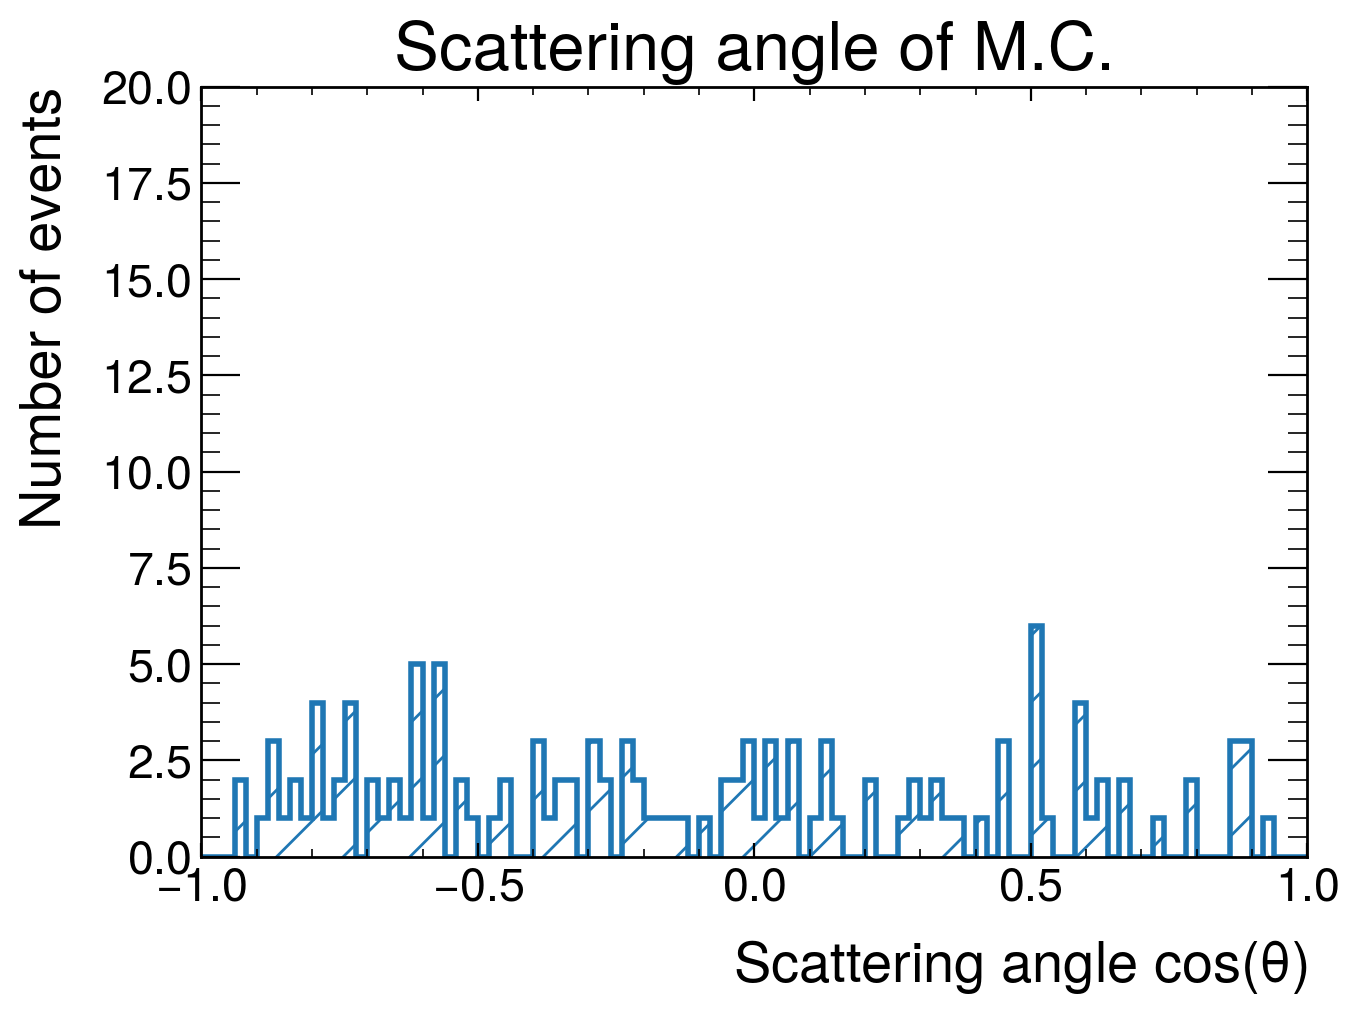

In [81]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')
x_min =-1
x_max = 1
bin_content, bin_edges, _ = plt.hist(costhetopal[opalMcuts[0]], bins=100, range=(x_min,x_max), histtype='step',  linewidth=2, hatch='/')
#bin_content, bin_edges, _ = plt.hist(costhetopal[opalMcuts[1]], bins=1000, range=(x_min,x_max), histtype='step',  linewidth=2, hatch='/')
#bin_content, bin_edges, _ = plt.hist(costhetopal[opalMcuts[2]], bins=1000, range=(x_min,x_max), histtype='step',  linewidth=2, hatch='/')
#bin_content, bin_edges, _ = plt.hist(costhetopal[opalMcuts[3]], bins=1000, range=(x_min,x_max), histtype='step',  linewidth=2, hatch='/')
#bin_content, bin_edges, _ = plt.hist(costhetopal[opalMcuts[4]], bins=1000, range=(x_min,x_max), histtype='step',  linewidth=2, hatch='/')
#bin_content, bin_edges, _ = plt.hist(costhetopal[opalMcuts[5]], bins=1000, range=(x_min,x_max), histtype='step',  linewidth=2, hatch='/')
#bin_content, bin_edges, _ = plt.hist(costhetopal[opalMcuts[6]], bins=1000, range=(x_min,x_max), histtype='step',  linewidth=2, hatch='/')



#bin_content, bin_edges, _ = plt.hist(costhet[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title('Scattering angle of M.C.')
plt.xlim(x_min,x_max)
plt.ylim(0,20)
plt.xlabel(r'Scattering angle $cos(\theta)$')
plt.ylabel('Number of events')
plt.show()

# Exercise 4: Tests on lepton universality¶

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.

# Grope Data

In [396]:
G_runs = [0] * 5
G_events = [0] * 5
G_eleps = [0] * 5
G_nchares = [0] * 5
G_pchares = [0] * 5
G_eecals = [0] * 5
G_ehcals = [0] * 5

fs = ['ee', 'mm', 'tt', 'qq']

j = 0
while j < 4:
    eefile = open('opal_data/grope/'+fs[j]+'_ex.txt').read()
    eefile = eefile.split('\n')

    N = len(eefile) - 1
    #print(N)

    e_run = [0] * N
    e_event = [0] * N
    e_elep = [0] * N
    e_nchare = [0] * N
    e_pchare = [0] * N
    #e_ = [0] * N
    e_eecal = [0] * N
    #
    e_ehcal = [0] * N
    #

    for i in range(1,N):
        #print(j,i)
        if j == 0:
            line = eefile[i].split('\t')
            e_run[i] = float(line[0])
            e_event[i] = float(line[1])
            e_elep[i] = float(line[2])
            e_nchare[i] = float(line[3])
            e_pchare[i] = float(line[4])
            e_eecal[i] = float(line[6])
            e_ehcal[i] = float(line[8])
        else:
            line = eefile[i].split('\t')
            e_run[i] = float(line[0])
            e_event[i] =float(line[1])
            e_elep[i] = float(line[2])
            e_nchare[i] = float(line[3])
            
            try:
                e_pchare[i] = float(line[4])
            except:
                e_pchare[i] = 0
            try:
                e_eecal[i] = float(line[5])
            except:
                e_eecal[i] = 0
            e_ehcal[i] = float(line[6])
    
    G_runs[j] = e_run
    G_events[j] = e_event
    G_eleps[j] = e_elep
    G_nchares[j] = e_nchare
    G_pchares[j] = e_pchare
    G_eecals[j] = e_eecal
    G_ehcals[j] = e_ehcal
    
    j += 1

In [397]:
G_pchares[0]

[0,
 0.0,
 84.4,
 92.2,
 0.0,
 78.5,
 83.8,
 0.0,
 0.0,
 71.0,
 0.0,
 71.6,
 71.3,
 74.4,
 0.0,
 83.2,
 47.9,
 65.1,
 82.5,
 0.0,
 0.0,
 0.0,
 2.0,
 59.9,
 78.9,
 0.0,
 0.0,
 90.2,
 47.9,
 85.8,
 0.0,
 87.0,
 52.4,
 82.4,
 90.4,
 66.5,
 0.0,
 0.0,
 575.6,
 36.5,
 0.0,
 42.7,
 84.0,
 57.4,
 0.0,
 69.7,
 10.8,
 0.0,
 90.5,
 0.0,
 90.3]

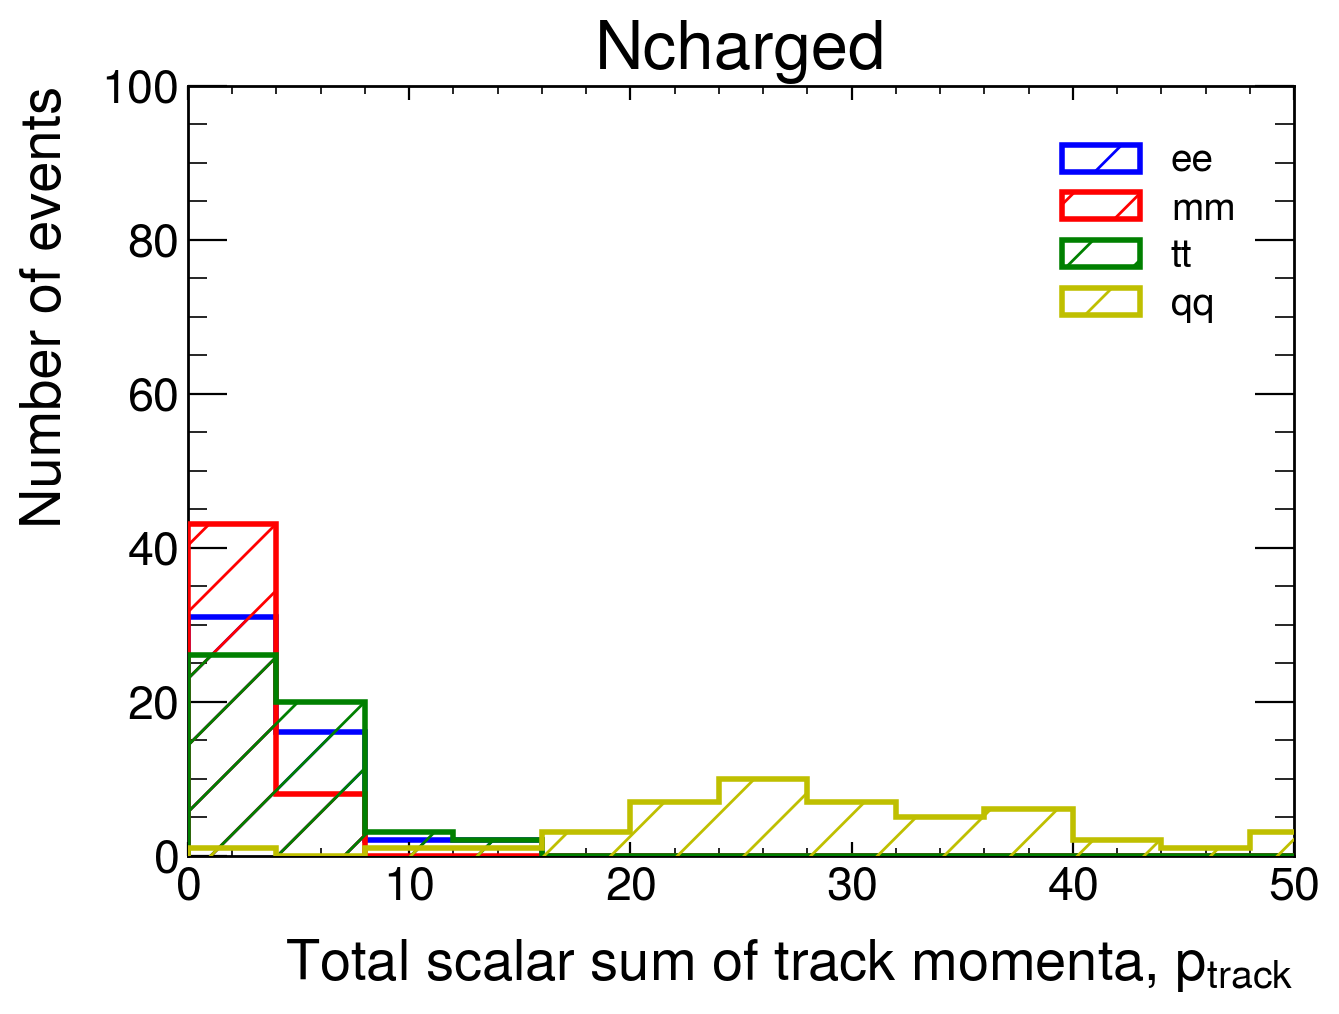

In [398]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(G_nchares[0], bins=25, range=(0.,100.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='ee', zorder=2)
bin_content, bin_edges, _ = plt.hist(G_nchares[1], bins=25, range=(0.,100.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='mm', zorder=3)
bin_content, bin_edges, _ = plt.hist(G_nchares[2], bins=25, range=(0.,100.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='tt', zorder=4)
bin_content, bin_edges, _ = plt.hist(G_nchares[3], bins=25, range=(0.,100.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='qq', zorder=5)
#bin_content, bin_edges, _ = plt.hist(G_nchares[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[0])
plt.xlim(0.,50)
plt.ylim(0,1e2)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

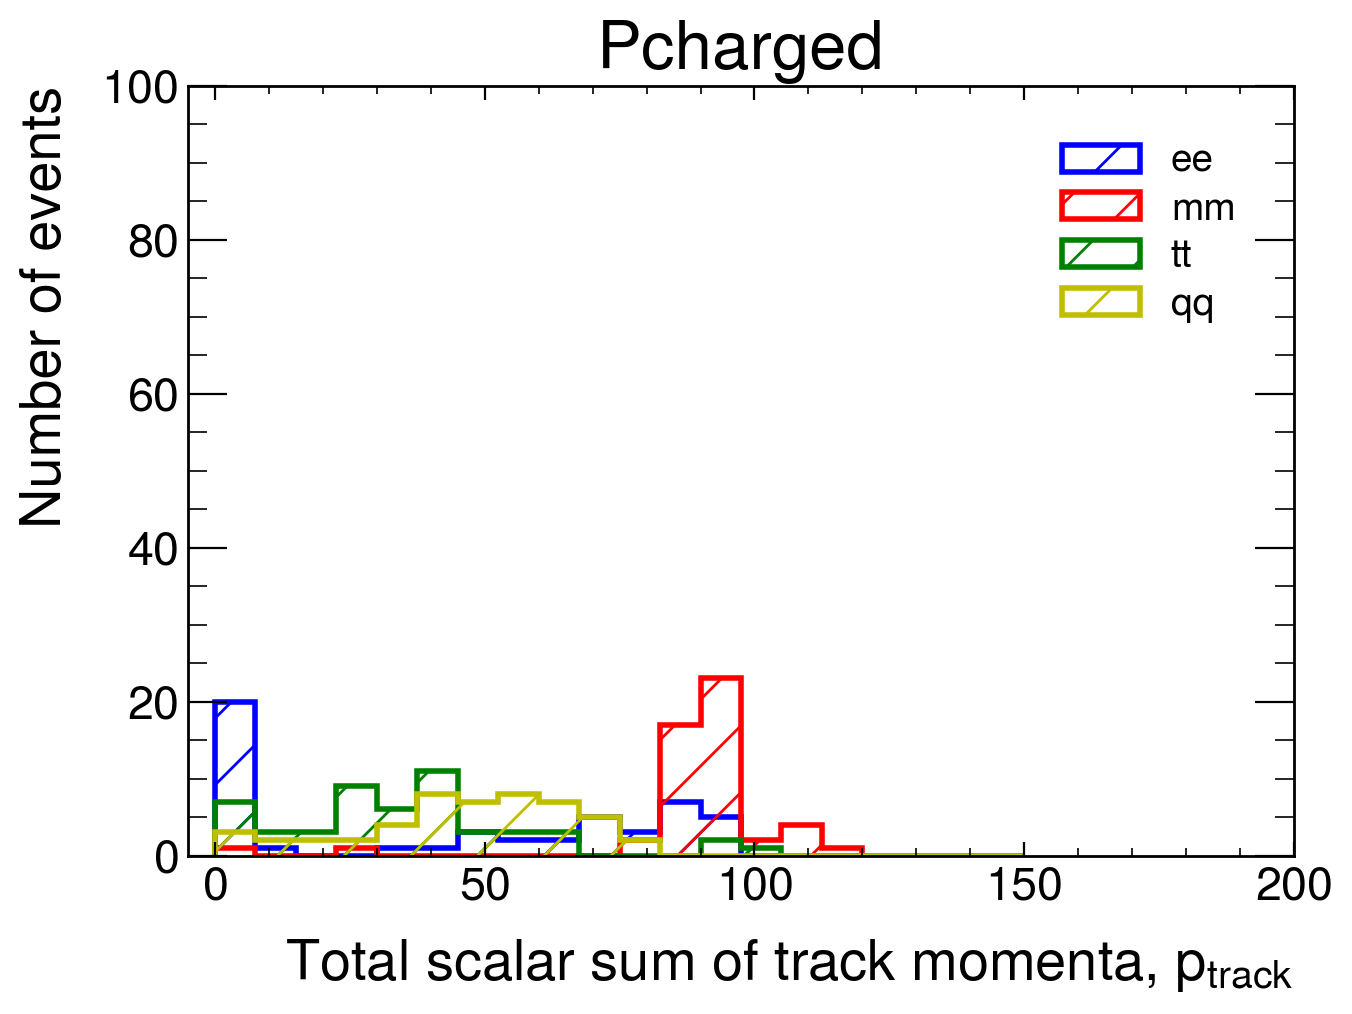

In [402]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(G_pchares[0], bins=20, range=(0.,150.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='ee')
bin_content, bin_edges, _ = plt.hist(G_pchares[1], bins=20, range=(0.,150.),histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='mm')
bin_content, bin_edges, _ = plt.hist(G_pchares[2], bins=20, range=(0.,150.),histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='tt')
bin_content, bin_edges, _ = plt.hist(G_pchares[3], bins=20, range=(0.,150.),histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='qq')
#bin_content, bin_edges, _ = plt.hist(G_pchares[4], bins=20, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


#mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

#error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[1])
plt.xlim(-5,200.)
plt.ylim(0,1e2)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

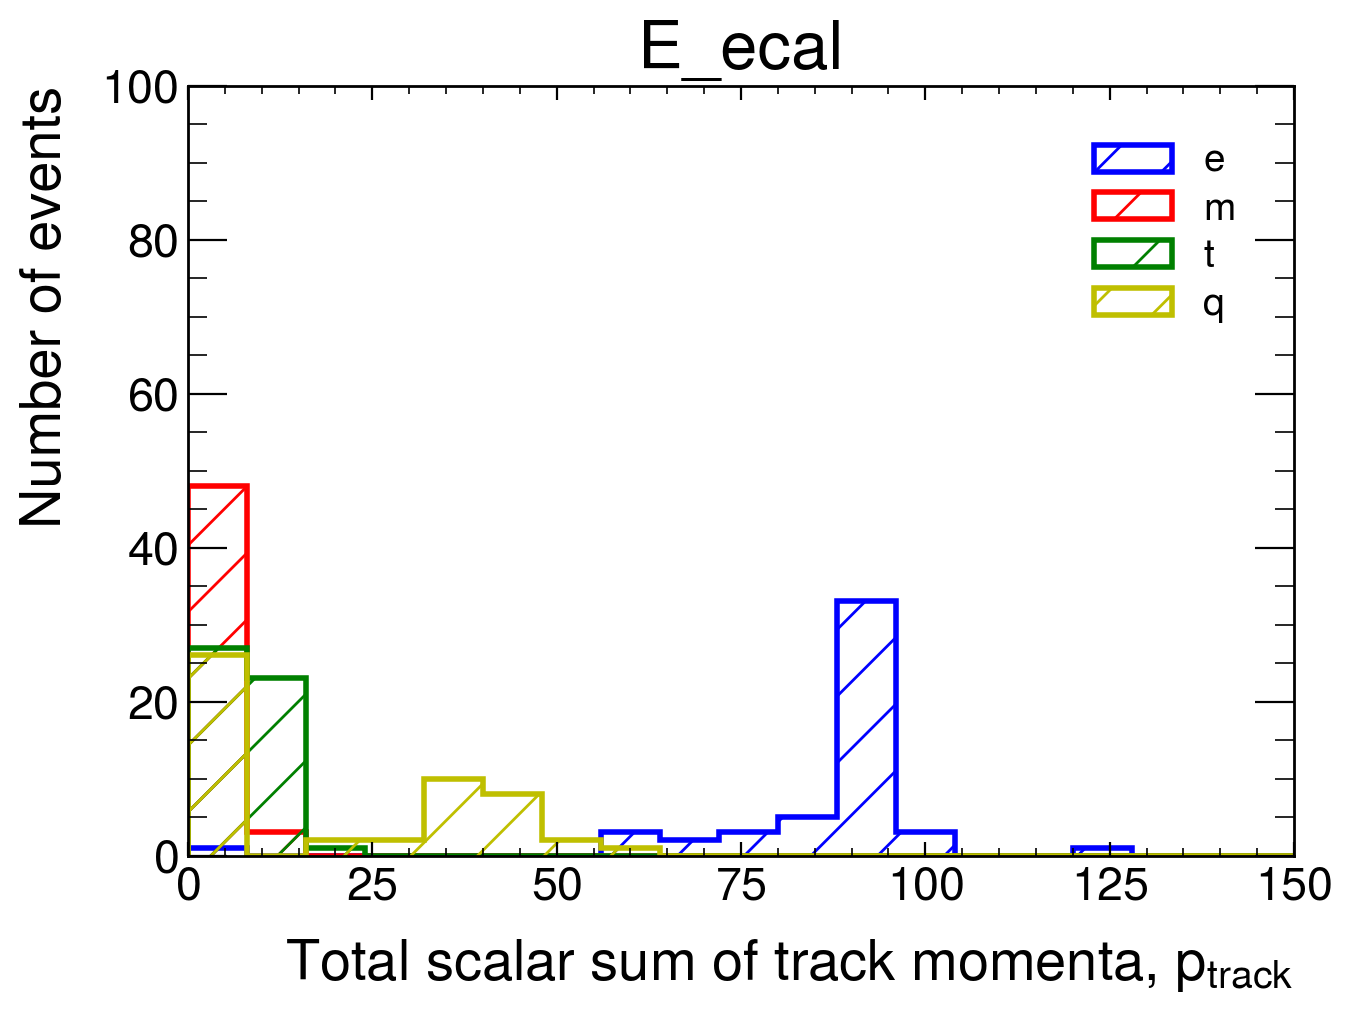

In [404]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(G_eecals[0], bins=25, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(G_eecals[1], bins=25, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(G_eecals[2], bins=25, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(G_eecals[3], bins=25, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')
#bin_content, bin_edges, _ = plt.hist(G_eecal[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


#mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

#error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[2])
plt.xlim(0.,150.)
plt.ylim(0,1e2)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

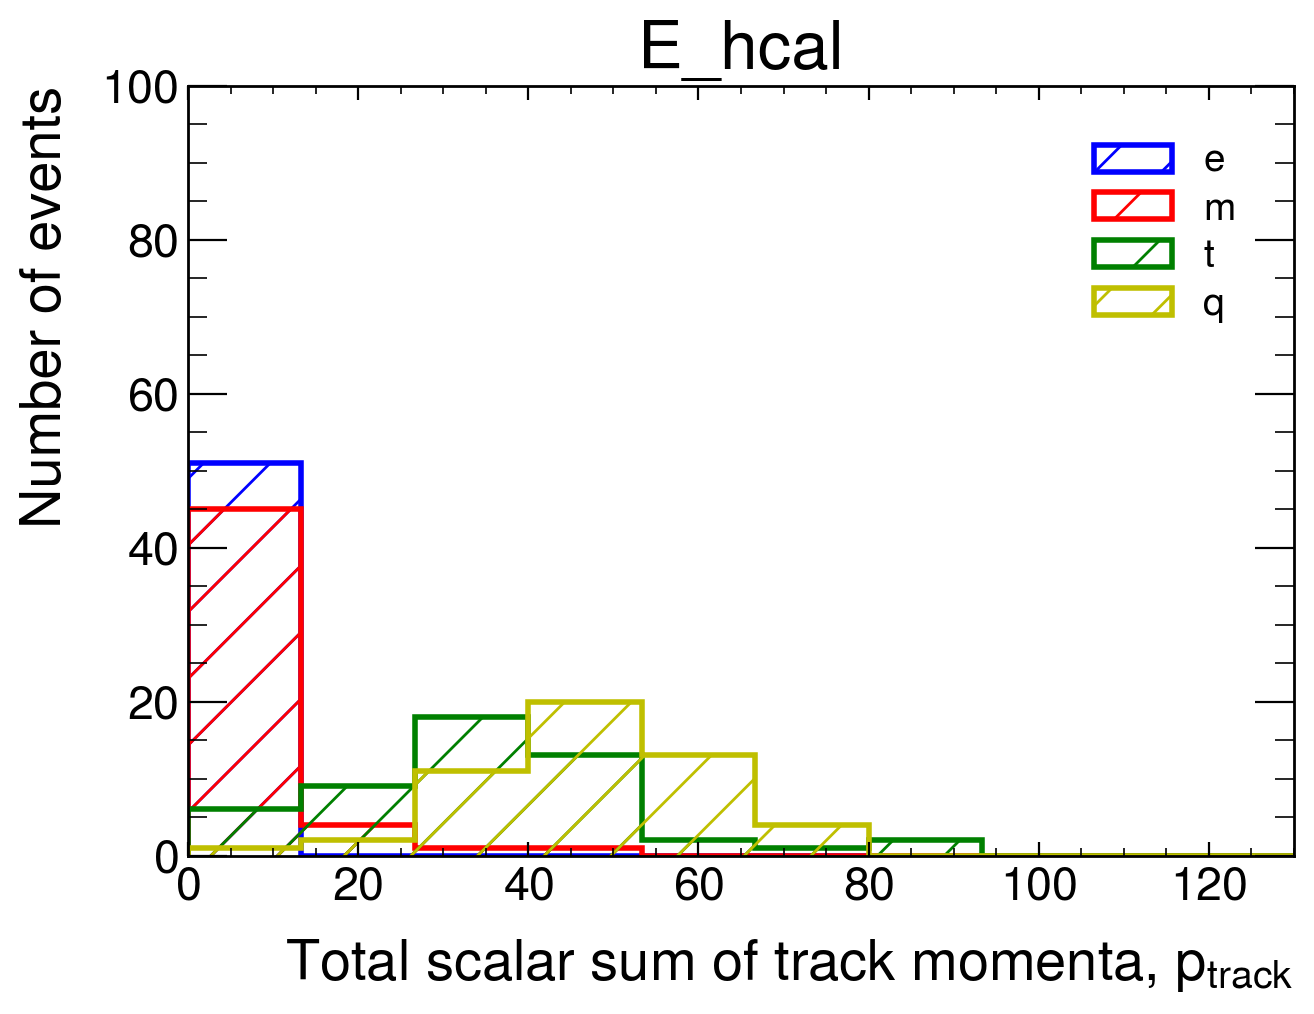

In [401]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

#bin_content, bin_edges, _ = plt.hist(pchar[mymask], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')

bin_content, bin_edges, _ = plt.hist(G_ehcals[0], bins=15, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='e')
bin_content, bin_edges, _ = plt.hist(G_ehcals[1], bins=15, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='r', hatch='/', label='m')
bin_content, bin_edges, _ = plt.hist(G_ehcals[2], bins=15, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='g', hatch='/', label='t')
bin_content, bin_edges, _ = plt.hist(G_ehcals[3], bins=15, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='y', hatch='/', label='q')
#bin_content, bin_edges, _ = plt.hist(G_ehcals[4], bins=1000, range=(0.,200.), histtype='step',  linewidth=2, edgecolor='black', hatch='/', label='sum', zorder=1)


mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

#plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none', label='Errors')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.legend()
plt.title(var[3])
plt.xlim(0.,130)
plt.ylim(0,1e2)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()